In [2]:
import numpy as np
from keras.datasets import cifar10
import matplotlib.pyplot as plt
import sys

C:\Users\Kozyrevsky-V\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
def encode_lable(y, num_classes):
    y_gt = np.zeros((len(y), num_classes))
    for i in range(0, len(y)):
        y_gt[i, y[i]] = 1
    return y_gt

In [4]:
def h(theta, X):
    return 1.0 / (1 + np.exp(-np.dot(X, theta)))

In [5]:
def sigm_derivative(theta, X):
    return h(theta, X) * (1 - h(theta, X))

In [6]:
def loss(y_gt, y_pred):
    cross_entropy_error = 0.0
    for i in range(0, len(y_gt)):
        for j in range(0, len(y_gt[i])):
            cross_entropy_error -= (y_gt[i][j] * np.log(y_pred[i][j]) + (1 - y_gt[i][j]) * np.log(1 - y_pred[i][j]))
    return cross_entropy_error / len(y_gt)

In [7]:
def CEderivative(X, y_gt, y_pred):
    return np.dot(y_pred - y_gt, X) / len(y_gt)

In [8]:
def acc(y_test, y_out):
    accuracy = 0
    for i in range(len(y_out)):
        if np.argmax(y_test[i]) == np.argmax(y_out[i]):
            accuracy += 1
    return accuracy / len(y_test)

In [9]:
def RMSprob(Et_1, g, gamma, mu, e):
    Et = (gamma*Et_1) + (1-gamma)*(g**2)
    delta = (mu)/np.sqrt(Et + e)
    delta*=g
    return Et, delta 

In [25]:
def Adadelta(Et_1, g, gamma, RMS_1, e):
    Et = (gamma*Et_1) + (1-gamma)*(g**2)
    RMS = np.sqrt(Et + e)
    delta = (RMS_1/RMS)*g
    return Et, RMS, delta

In [10]:
def forward(thetas, X, dropout_prob, train_test_check):
    num_layers = thetas.shape[0]
    outs = []
    for t in range(0, num_layers): #проходим по всем слоям (все слои с сигмоидальной функцией активации)
        if t == 0:
            outs.append(np.array([h(thetas[t][:, i], X) for i in range(0, thetas[t].shape[1])]).T)
        else:
            outs.append(np.array([h(thetas[t][:, i], np.asarray(outs[t-1])) for i in range(0, thetas[t].shape[1])]).T)
    #Dropout
    if train_test_check:
        for i in range(len(outs) - 1):#для всех слоев кроме выходного и входного
            for o in outs[i]:
                o *= np.random.binomial(1,dropout_prob,o.shape[0]) * (1) / (dropout_prob)
    return [out for out in outs]

In [11]:
def backward(X, y_gt, thetas, dropout_prob):
    num_features = X.shape[1]
    num_classes = y_gt.shape[1]
    outs = forward(thetas, X,dropout_prob, True)
    num_layers = len(outs)
    d_theta = []
    d_theta.append(np.zeros([num_features, outs[0].shape[1]]))
    for i in range(0, num_layers - 1):
        d_theta.append(np.zeros([outs[i].shape[1], outs[i+1].shape[1]]))
    tmp_th = None
    #скрытые слои
    for i in range(len(outs) - 1, -1, -1):
        if i == len(outs) - 1:#выходной слой
            for class_no in range(0, num_classes):
                d_theta[i][:, class_no] = CEderivative(outs[i-1], y_gt[:, class_no], outs[i][:, class_no])
            tmp_th = outs[i] - y_gt
        elif i == 0:#первый скрытый
            tmp_th = np.dot(tmp_th, thetas[1].T)
            tmp_th = tmp_th * sigm_derivative(thetas[0], X)
            d_theta[0] = np.dot(X.T, tmp_th)
            d_theta[0] = d_theta[0]/outs[0].shape[0]
        else:# остальные скрытые
            tmp_th = np.dot(tmp_th, thetas[i+1].T)
            tmp_th = tmp_th * sigm_derivative(thetas[i], outs[i-1])
            d_theta[i] = np.dot(outs[i-1].T, tmp_th)
            d_theta[i] = d_theta[i]/outs[i].shape[0]
    return d_theta

In [12]:
(dx_train, dy_train), (x_test, y_test) = cifar10.load_data()

In [13]:
print('x_train shape:', dx_train.shape)
print(dx_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [14]:
dy_train = encode_lable(dy_train, 10)
y_test = encode_lable(y_test, 10)

In [15]:
dx_train = np.asarray([list(x.flat) for x in dx_train])
x_test = np.asarray([list(x.flat) for x in x_test])

In [16]:
p = np.random.permutation(dx_train.shape[0])
x_train = dx_train[p[0:int(len(dx_train)*0.8)], :]
y_train = dy_train[p[0:int(len(dx_train)*0.8)]]
x_val = dx_train[p[int(len(dx_train)*0.8):], :]
y_val = dy_train[p[int(len(dx_train)*0.8):]]
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_val shape:", x_val.shape)
print("y_val shape:", y_val.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_train shape: (40000, 3072)
y_train shape: (40000, 10)
x_val shape: (10000, 3072)
y_val shape: (10000, 10)
x_test shape: (10000, 3072)
y_test shape: (10000, 10)


In [17]:
x_train = (x_train - np.mean(x_train, axis = 0)) / np.var(x_train, axis = 0)
x_val = (x_val - np.mean(x_val, axis = 0)) / np.var(x_val, axis = 0)
x_test = (x_test - np.mean(x_test, axis = 0)) / np.var(x_test, axis = 0)

In [18]:
def init_thetas(layers_size):
    np.random.seed(0)
    list_thetas = []
    for i in range(0, len(layers_size)-2):
        list_thetas.append(np.random.uniform(-1*pow(layers_size[i+1], (1/float(layers_size[i]))), pow(layers_size[i+1], (1/float(layers_size[i]))), (layers_size[i], layers_size[i+1])))
    list_thetas.append(np.random.uniform(-0.5, 0.5,(layers_size[-2], layers_size[-1])))
    return np.asarray(list_thetas)

In [19]:
def another_init_thetas(layers_size):
    list_thetas = []
    for i in range(0, len(layers_size) - 1):
        r = (4*(6/(layers_size[i] + layers_size[i+1]))**1/2)
        list_thetas.append(np.random.uniform(-1*r, r, (layers_size[i], layers_size[i+1])))
    return np.asarray(list_thetas)

Initial loss : 17.533492110292432


Epoch 0/500 ..............
Loss train:  3.411635113217959 
Loss val:  3.399269411155359 
Train accuracy:  0.206325 
Validation accuracy:  0.209
Alpha:  0.1


Epoch 1/500 ..............
Loss train:  3.2018320360622066 
Loss val:  3.218213209092094 
Train accuracy:  0.217075 
Validation accuracy:  0.2173
Alpha:  0.1


Epoch 2/500 ..............
Loss train:  2.930123209666781 
Loss val:  2.9409498315008005 
Train accuracy:  0.2863 
Validation accuracy:  0.2809
Alpha:  0.1


Epoch 3/500 ..............
Loss train:  2.985720488906524 
Loss val:  2.9996409527480896 
Train accuracy:  0.25405 
Validation accuracy:  0.2466
Alpha:  0.1


Epoch 4/500 ..............
Loss train:  2.9048772869211046 
Loss val:  2.917002930635403 
Train accuracy:  0.296125 
Validation accuracy:  0.2962
Alpha:  0.05


Epoch 5/500 ..............
Loss train:  2.8972793676286632 
Loss val:  2.9119716590869174 
Train accuracy:  0.292525 
Validation accuracy:  0.2893
Alpha:  0.05


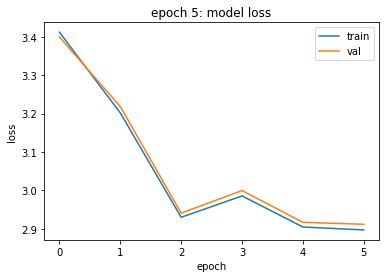

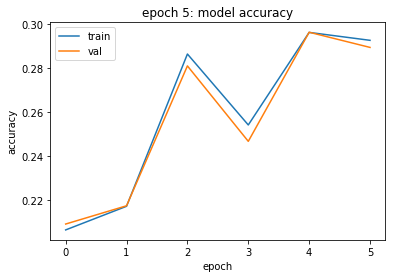



Epoch 6/500 ..............
Loss train:  2.8690444252103435 
Loss val:  2.8900046861999 
Train accuracy:  0.31025 
Validation accuracy:  0.3017
Alpha:  0.05


Epoch 7/500 ..............
Loss train:  2.8246649171097684 
Loss val:  2.837949056551791 
Train accuracy:  0.321075 
Validation accuracy:  0.3208
Alpha:  0.05


Epoch 8/500 ..............
Loss train:  2.8325509205533397 
Loss val:  2.851149542463644 
Train accuracy:  0.324925 
Validation accuracy:  0.3209
Alpha:  0.05


Epoch 9/500 ..............
Loss train:  2.8477680942967183 
Loss val:  2.8665924643602105 
Train accuracy:  0.30795 
Validation accuracy:  0.2999
Alpha:  0.025


Epoch 10/500 ..............
Loss train:  2.8305780321314282 
Loss val:  2.851427249513913 
Train accuracy:  0.31615 
Validation accuracy:  0.3109
Alpha:  0.0125


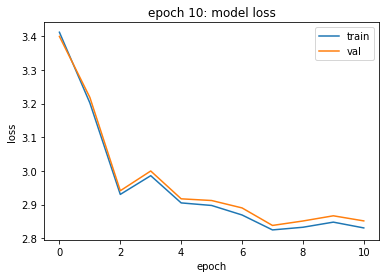

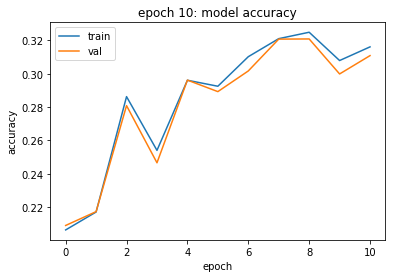



Epoch 11/500 ..............
Loss train:  2.76674128985869 
Loss val:  2.788704856054881 
Train accuracy:  0.347625 
Validation accuracy:  0.3343
Alpha:  0.0125


Epoch 12/500 ..............
Loss train:  2.8039679602531953 
Loss val:  2.8235821270979744 
Train accuracy:  0.328075 
Validation accuracy:  0.3248
Alpha:  0.0125


Epoch 13/500 ..............
Loss train:  2.7788851810567556 
Loss val:  2.7991225176979286 
Train accuracy:  0.339225 
Validation accuracy:  0.3329
Alpha:  0.00625


Epoch 14/500 ..............
Loss train:  2.7403679067873927 
Loss val:  2.761494984004291 
Train accuracy:  0.3519 
Validation accuracy:  0.3486
Alpha:  0.00625


Epoch 15/500 ..............
Loss train:  2.746591606191301 
Loss val:  2.7676746190881283 
Train accuracy:  0.344325 
Validation accuracy:  0.3391
Alpha:  0.00625


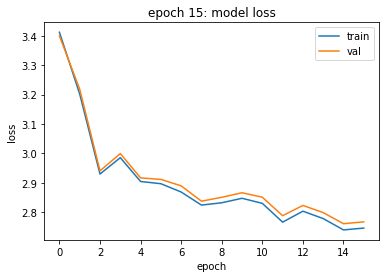

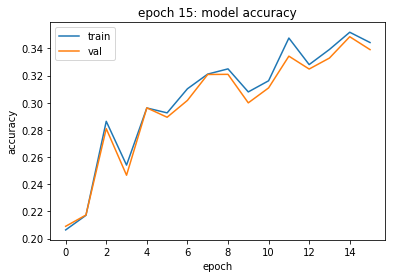



Epoch 16/500 ..............
Loss train:  2.7354653682191192 
Loss val:  2.7568744418605866 
Train accuracy:  0.35165 
Validation accuracy:  0.3441
Alpha:  0.003125


Epoch 17/500 ..............
Loss train:  2.734811860368527 
Loss val:  2.7586170204373097 
Train accuracy:  0.34485 
Validation accuracy:  0.335
Alpha:  0.003125


Epoch 18/500 ..............
Loss train:  2.7392843338166606 
Loss val:  2.760751763544635 
Train accuracy:  0.34935 
Validation accuracy:  0.3438
Alpha:  0.0015625


Epoch 19/500 ..............
Loss train:  2.7061639795105066 
Loss val:  2.731461476354541 
Train accuracy:  0.357275 
Validation accuracy:  0.35
Alpha:  0.001


Epoch 20/500 ..............
Loss train:  2.6914838585094603 
Loss val:  2.712723079163587 
Train accuracy:  0.364375 
Validation accuracy:  0.354
Alpha:  0.001


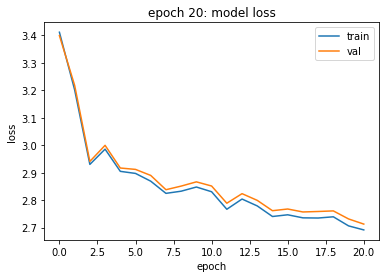

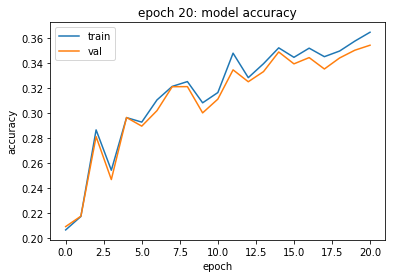



Epoch 21/500 ..............
Loss train:  2.68758295386508 
Loss val:  2.710515362100703 
Train accuracy:  0.3692 
Validation accuracy:  0.362
Alpha:  0.001


Epoch 22/500 ..............
Loss train:  2.6769329352720437 
Loss val:  2.7039487987042166 
Train accuracy:  0.3673 
Validation accuracy:  0.3521
Alpha:  0.001


Epoch 23/500 ..............
Loss train:  2.6660146390413155 
Loss val:  2.6909911648093803 
Train accuracy:  0.375825 
Validation accuracy:  0.3691
Alpha:  0.001


Epoch 24/500 ..............
Loss train:  2.680328971084267 
Loss val:  2.707490954656156 
Train accuracy:  0.367525 
Validation accuracy:  0.3647
Alpha:  0.001


Epoch 25/500 ..............
Loss train:  2.6504046391389724 
Loss val:  2.676154256178276 
Train accuracy:  0.38225 
Validation accuracy:  0.3751
Alpha:  0.001


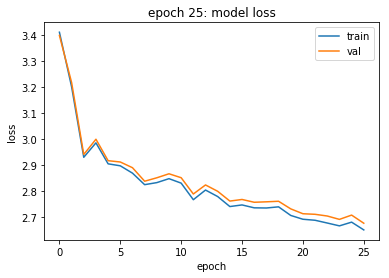

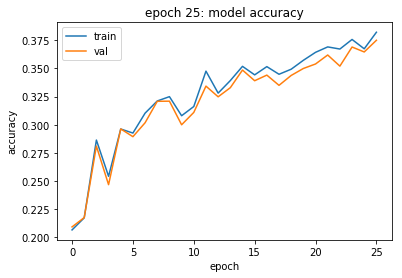



Epoch 26/500 ..............
Loss train:  2.648283622151611 
Loss val:  2.6752080334564465 
Train accuracy:  0.377025 
Validation accuracy:  0.3693
Alpha:  0.001


Epoch 27/500 ..............
Loss train:  2.6365208571195975 
Loss val:  2.6616146114350125 
Train accuracy:  0.384375 
Validation accuracy:  0.3772
Alpha:  0.001


Epoch 28/500 ..............
Loss train:  2.6400475966602084 
Loss val:  2.6669690158234376 
Train accuracy:  0.37785 
Validation accuracy:  0.3673
Alpha:  0.001


Epoch 29/500 ..............
Loss train:  2.627239181191433 
Loss val:  2.654491251783608 
Train accuracy:  0.3883 
Validation accuracy:  0.3787
Alpha:  0.001


Epoch 30/500 ..............
Loss train:  2.6401518753501767 
Loss val:  2.6647353012072648 
Train accuracy:  0.37775 
Validation accuracy:  0.3725
Alpha:  0.001


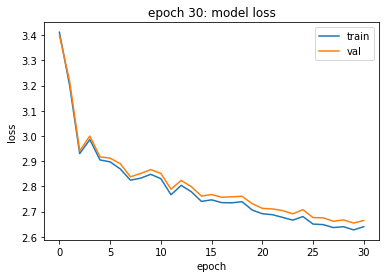

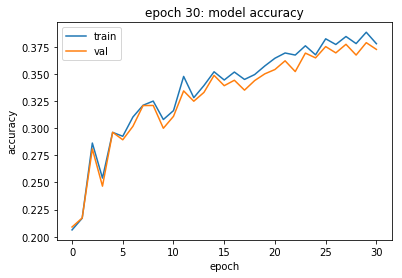



Epoch 31/500 ..............
Loss train:  2.6528247190279783 
Loss val:  2.6759971191542684 
Train accuracy:  0.37515 
Validation accuracy:  0.3647
Alpha:  0.001


Epoch 32/500 ..............
Loss train:  2.617593067942552 
Loss val:  2.646508444350011 
Train accuracy:  0.38815 
Validation accuracy:  0.3794
Alpha:  0.001


Epoch 33/500 ..............
Loss train:  2.6156001251913867 
Loss val:  2.644800723784651 
Train accuracy:  0.3886 
Validation accuracy:  0.3748
Alpha:  0.001


Epoch 34/500 ..............
Loss train:  2.6027597490944197 
Loss val:  2.6317562775121877 
Train accuracy:  0.39065 
Validation accuracy:  0.3795
Alpha:  0.001


Epoch 35/500 ..............
Loss train:  2.608938029750828 
Loss val:  2.637774232321095 
Train accuracy:  0.385375 
Validation accuracy:  0.374
Alpha:  0.001


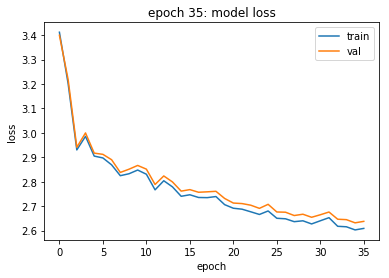

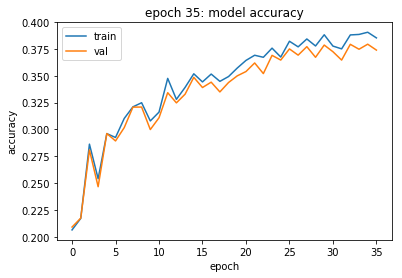



Epoch 36/500 ..............
Loss train:  2.6098231039387563 
Loss val:  2.637374884048419 
Train accuracy:  0.393775 
Validation accuracy:  0.3885
Alpha:  0.001


Epoch 37/500 ..............
Loss train:  2.592442464430885 
Loss val:  2.6227641786390237 
Train accuracy:  0.3914 
Validation accuracy:  0.3835
Alpha:  0.001


Epoch 38/500 ..............
Loss train:  2.605960772715611 
Loss val:  2.636950278614576 
Train accuracy:  0.385125 
Validation accuracy:  0.3686
Alpha:  0.001


Epoch 39/500 ..............
Loss train:  2.5819597692511542 
Loss val:  2.6120477922485814 
Train accuracy:  0.395525 
Validation accuracy:  0.3867
Alpha:  0.001


Epoch 40/500 ..............
Loss train:  2.574721047898675 
Loss val:  2.605622777029326 
Train accuracy:  0.400275 
Validation accuracy:  0.3905
Alpha:  0.001


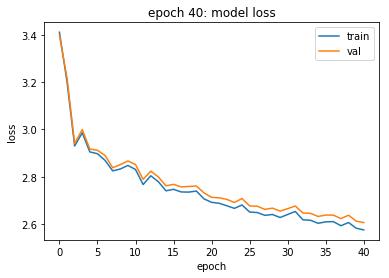

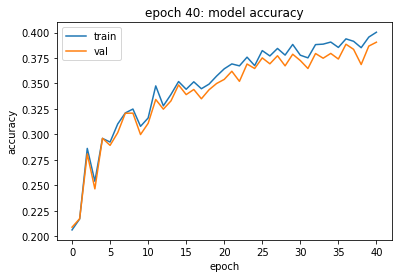



Epoch 41/500 ..............
Loss train:  2.5654098478541205 
Loss val:  2.596610902033261 
Train accuracy:  0.4059 
Validation accuracy:  0.3956
Alpha:  0.001


Epoch 42/500 ..............
Loss train:  2.5780067193240748 
Loss val:  2.606476437525542 
Train accuracy:  0.397825 
Validation accuracy:  0.3873
Alpha:  0.001


Epoch 43/500 ..............
Loss train:  2.5570150594814707 
Loss val:  2.5879165539008406 
Train accuracy:  0.40595 
Validation accuracy:  0.3939
Alpha:  0.001


Epoch 44/500 ..............
Loss train:  2.5636405083475213 
Loss val:  2.592859925808569 
Train accuracy:  0.405925 
Validation accuracy:  0.3983
Alpha:  0.001


Epoch 45/500 ..............
Loss train:  2.552509802742916 
Loss val:  2.5836517816952504 
Train accuracy:  0.408525 
Validation accuracy:  0.4014
Alpha:  0.001


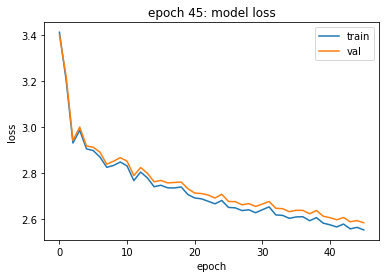

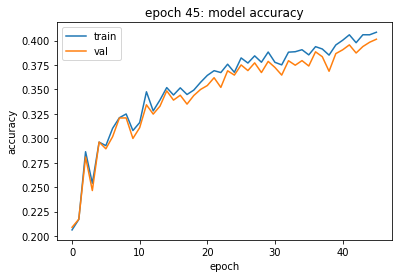



Epoch 46/500 ..............
Loss train:  2.591102503679943 
Loss val:  2.627719806338601 
Train accuracy:  0.3885 
Validation accuracy:  0.3765
Alpha:  0.001


Epoch 47/500 ..............
Loss train:  2.54963394171941 
Loss val:  2.5831364986443774 
Train accuracy:  0.407125 
Validation accuracy:  0.3939
Alpha:  0.001


Epoch 48/500 ..............
Loss train:  2.5471834634454678 
Loss val:  2.5794302835497356 
Train accuracy:  0.411 
Validation accuracy:  0.4032
Alpha:  0.001


Epoch 49/500 ..............
Loss train:  2.548069399732482 
Loss val:  2.5817824590751903 
Train accuracy:  0.410325 
Validation accuracy:  0.4005
Alpha:  0.001


Epoch 50/500 ..............
Loss train:  2.555138723375644 
Loss val:  2.584394578540125 
Train accuracy:  0.40495 
Validation accuracy:  0.3935
Alpha:  0.001


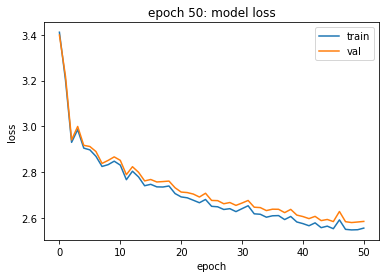

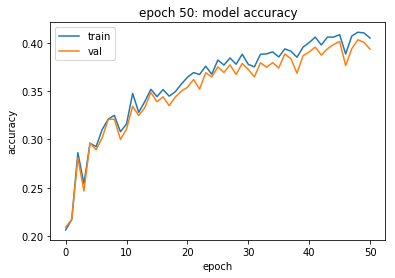



Epoch 51/500 ..............
Loss train:  2.5296655914490582 
Loss val:  2.562686081758725 
Train accuracy:  0.41 
Validation accuracy:  0.4028
Alpha:  0.001


Epoch 52/500 ..............
Loss train:  2.526925091300423 
Loss val:  2.562869926904793 
Train accuracy:  0.41605 
Validation accuracy:  0.403
Alpha:  0.001


Epoch 53/500 ..............
Loss train:  2.5226253211616565 
Loss val:  2.5591670311852583 
Train accuracy:  0.41685 
Validation accuracy:  0.4034
Alpha:  0.001


Epoch 54/500 ..............
Loss train:  2.5368440338893996 
Loss val:  2.568966751258608 
Train accuracy:  0.410875 
Validation accuracy:  0.4028
Alpha:  0.001


Epoch 55/500 ..............
Loss train:  2.513995405390358 
Loss val:  2.548068798752348 
Train accuracy:  0.4213 
Validation accuracy:  0.4109
Alpha:  0.001


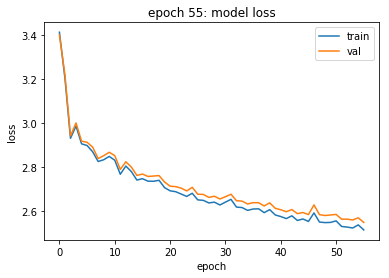

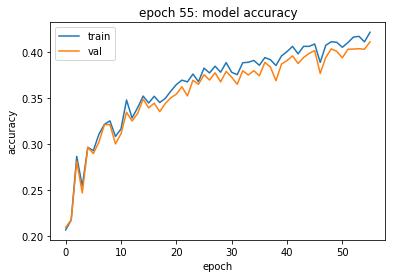



Epoch 56/500 ..............
Loss train:  2.51269956721095 
Loss val:  2.5478977831739833 
Train accuracy:  0.422775 
Validation accuracy:  0.4104
Alpha:  0.001


Epoch 57/500 ..............
Loss train:  2.51740217354728 
Loss val:  2.5550258835367154 
Train accuracy:  0.41795 
Validation accuracy:  0.4035
Alpha:  0.001


Epoch 58/500 ..............
Loss train:  2.505876581644629 
Loss val:  2.5420374644158144 
Train accuracy:  0.42125 
Validation accuracy:  0.413
Alpha:  0.001


Epoch 59/500 ..............
Loss train:  2.4968181399794305 
Loss val:  2.5356509184928946 
Train accuracy:  0.423325 
Validation accuracy:  0.4095
Alpha:  0.001


Epoch 60/500 ..............
Loss train:  2.497994847028248 
Loss val:  2.535020451119947 
Train accuracy:  0.4243 
Validation accuracy:  0.4105
Alpha:  0.001


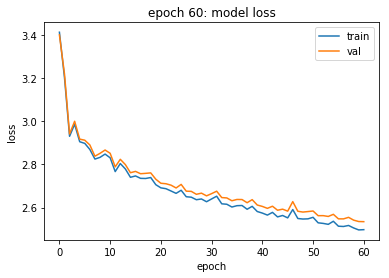

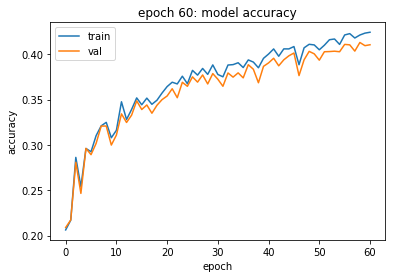



Epoch 61/500 ..............
Loss train:  2.50557192476065 
Loss val:  2.5424535291130517 
Train accuracy:  0.422675 
Validation accuracy:  0.411
Alpha:  0.001


Epoch 62/500 ..............
Loss train:  2.501777140586418 
Loss val:  2.540764363749242 
Train accuracy:  0.42285 
Validation accuracy:  0.4089
Alpha:  0.001


Epoch 63/500 ..............
Loss train:  2.5110614533869517 
Loss val:  2.5552814968076127 
Train accuracy:  0.41515 
Validation accuracy:  0.3946
Alpha:  0.001


Epoch 64/500 ..............
Loss train:  2.490415564717726 
Loss val:  2.532457271804507 
Train accuracy:  0.41985 
Validation accuracy:  0.4096
Alpha:  0.001


Epoch 65/500 ..............
Loss train:  2.486631930721022 
Loss val:  2.526906190938126 
Train accuracy:  0.425525 
Validation accuracy:  0.4141
Alpha:  0.001


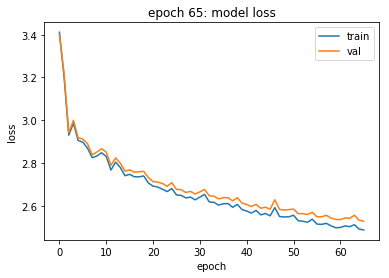

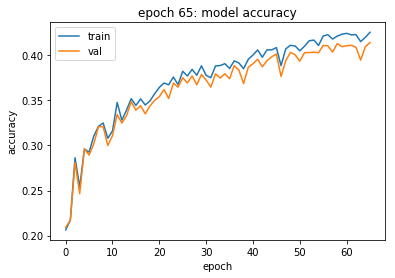



Epoch 66/500 ..............
Loss train:  2.5016639703533383 
Loss val:  2.538379331355962 
Train accuracy:  0.415725 
Validation accuracy:  0.4011
Alpha:  0.001


Epoch 67/500 ..............
Loss train:  2.4965753936432 
Loss val:  2.535147174210472 
Train accuracy:  0.424675 
Validation accuracy:  0.414
Alpha:  0.001


Epoch 68/500 ..............
Loss train:  2.4825282364954897 
Loss val:  2.520847360657581 
Train accuracy:  0.42585 
Validation accuracy:  0.4153
Alpha:  0.001


Epoch 69/500 ..............
Loss train:  2.4827022651882196 
Loss val:  2.522271545865997 
Train accuracy:  0.425625 
Validation accuracy:  0.4129
Alpha:  0.001


Epoch 70/500 ..............
Loss train:  2.47246970746557 
Loss val:  2.5102078244110784 
Train accuracy:  0.43085 
Validation accuracy:  0.4209
Alpha:  0.001


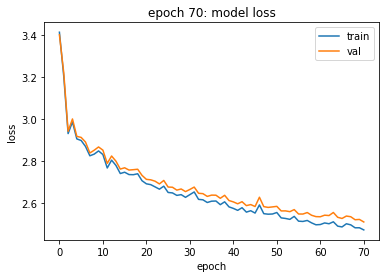

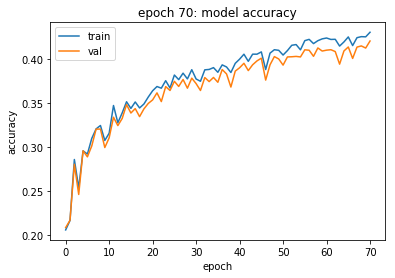



Epoch 71/500 ..............
Loss train:  2.473393870415162 
Loss val:  2.514778574040251 
Train accuracy:  0.423525 
Validation accuracy:  0.4102
Alpha:  0.001


Epoch 72/500 ..............
Loss train:  2.47064111609783 
Loss val:  2.512745603571118 
Train accuracy:  0.426525 
Validation accuracy:  0.4118
Alpha:  0.001


Epoch 73/500 ..............
Loss train:  2.4604688485625106 
Loss val:  2.5012263984057292 
Train accuracy:  0.4327 
Validation accuracy:  0.4184
Alpha:  0.001


Epoch 74/500 ..............
Loss train:  2.4702013531198648 
Loss val:  2.5128172889612084 
Train accuracy:  0.428825 
Validation accuracy:  0.4131
Alpha:  0.001


Epoch 75/500 ..............
Loss train:  2.4733502509173295 
Loss val:  2.51245676609702 
Train accuracy:  0.43225 
Validation accuracy:  0.4183
Alpha:  0.001


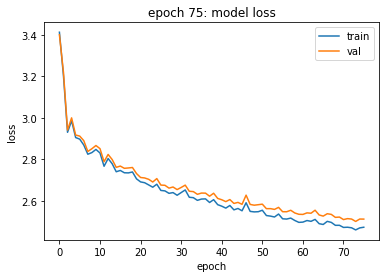

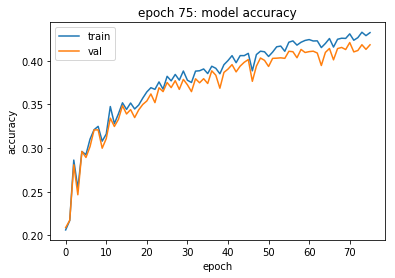



Epoch 76/500 ..............
Loss train:  2.461757753763542 
Loss val:  2.5045455928431744 
Train accuracy:  0.43395 
Validation accuracy:  0.4233
Alpha:  0.001


Epoch 77/500 ..............
Loss train:  2.464617789167812 
Loss val:  2.5108755756488184 
Train accuracy:  0.4328 
Validation accuracy:  0.4164
Alpha:  0.001


Epoch 78/500 ..............
Loss train:  2.461340749464661 
Loss val:  2.505550507861709 
Train accuracy:  0.432175 
Validation accuracy:  0.4175
Alpha:  0.001


Epoch 79/500 ..............
Loss train:  2.4461737839761732 
Loss val:  2.4917871436456234 
Train accuracy:  0.43905 
Validation accuracy:  0.4233
Alpha:  0.001


Epoch 80/500 ..............
Loss train:  2.4404128254480826 
Loss val:  2.482071710860888 
Train accuracy:  0.4421 
Validation accuracy:  0.432
Alpha:  0.001


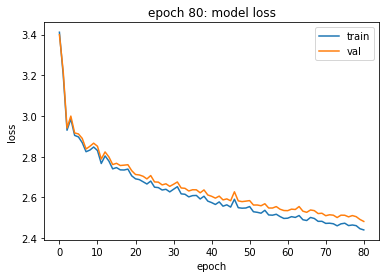

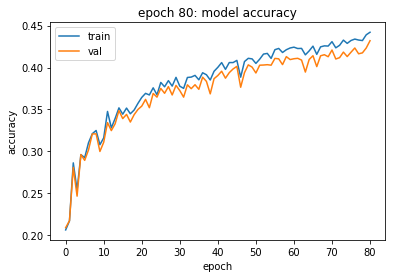



Epoch 81/500 ..............
Loss train:  2.4419177910201686 
Loss val:  2.4851850325510885 
Train accuracy:  0.439275 
Validation accuracy:  0.4242
Alpha:  0.001


Epoch 82/500 ..............
Loss train:  2.441945454895127 
Loss val:  2.4872771817042576 
Train accuracy:  0.442 
Validation accuracy:  0.429
Alpha:  0.001


Epoch 83/500 ..............
Loss train:  2.436565734702042 
Loss val:  2.4836854291743222 
Train accuracy:  0.44105 
Validation accuracy:  0.4237
Alpha:  0.001


Epoch 84/500 ..............
Loss train:  2.437582560145912 
Loss val:  2.481928046191265 
Train accuracy:  0.4399 
Validation accuracy:  0.4254
Alpha:  0.001


Epoch 85/500 ..............
Loss train:  2.428969535492448 
Loss val:  2.476979445389862 
Train accuracy:  0.441725 
Validation accuracy:  0.429
Alpha:  0.001


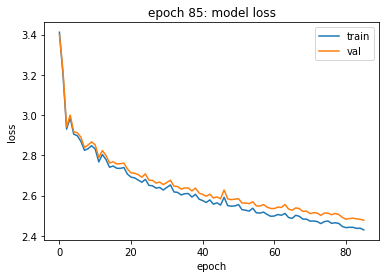

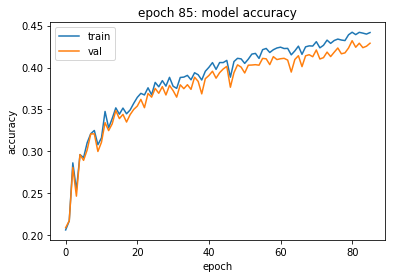



Epoch 86/500 ..............
Loss train:  2.441423874623747 
Loss val:  2.4914051453291783 
Train accuracy:  0.4354 
Validation accuracy:  0.416
Alpha:  0.001


Epoch 87/500 ..............
Loss train:  2.431409930434553 
Loss val:  2.477182982784434 
Train accuracy:  0.441325 
Validation accuracy:  0.4242
Alpha:  0.001


Epoch 88/500 ..............
Loss train:  2.4253085175445546 
Loss val:  2.475286890250304 
Train accuracy:  0.447325 
Validation accuracy:  0.4312
Alpha:  0.001


Epoch 89/500 ..............
Loss train:  2.4216656811253388 
Loss val:  2.4686502219348894 
Train accuracy:  0.446375 
Validation accuracy:  0.4282
Alpha:  0.001


Epoch 90/500 ..............
Loss train:  2.4393086164526396 
Loss val:  2.4867895118037504 
Train accuracy:  0.442625 
Validation accuracy:  0.4333
Alpha:  0.001


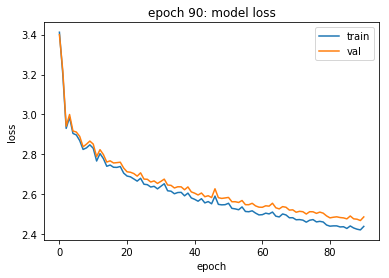

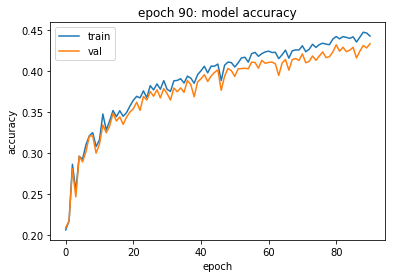



Epoch 91/500 ..............
Loss train:  2.423314392139962 
Loss val:  2.4684741375918433 
Train accuracy:  0.444525 
Validation accuracy:  0.4313
Alpha:  0.001


Epoch 92/500 ..............
Loss train:  2.4247874941653866 
Loss val:  2.4780173921254924 
Train accuracy:  0.44315 
Validation accuracy:  0.4285
Alpha:  0.001


Epoch 93/500 ..............
Loss train:  2.425198112847999 
Loss val:  2.4719714950885527 
Train accuracy:  0.4444 
Validation accuracy:  0.4337
Alpha:  0.001


Epoch 94/500 ..............
Loss train:  2.4173335091954944 
Loss val:  2.468014622111537 
Train accuracy:  0.4483 
Validation accuracy:  0.4337
Alpha:  0.001


Epoch 95/500 ..............
Loss train:  2.4689377370472894 
Loss val:  2.5228829719777934 
Train accuracy:  0.4297 
Validation accuracy:  0.4128
Alpha:  0.001


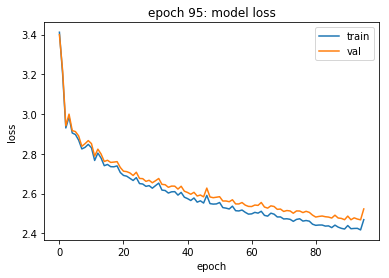

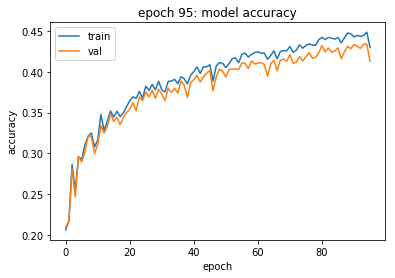



Epoch 96/500 ..............
Loss train:  2.414818215893044 
Loss val:  2.4660708784784138 
Train accuracy:  0.4499 
Validation accuracy:  0.4339
Alpha:  0.001


Epoch 97/500 ..............
Loss train:  2.4095364064306617 
Loss val:  2.4611069194564568 
Train accuracy:  0.448175 
Validation accuracy:  0.4339
Alpha:  0.001


Epoch 98/500 ..............
Loss train:  2.4048630395867194 
Loss val:  2.4560088676466645 
Train accuracy:  0.4514 
Validation accuracy:  0.4373
Alpha:  0.001


Epoch 99/500 ..............
Loss train:  2.4056652948935975 
Loss val:  2.457449890580363 
Train accuracy:  0.4489 
Validation accuracy:  0.431
Alpha:  0.001


Epoch 100/500 ..............
Loss train:  2.401136694456612 
Loss val:  2.454394337951672 
Train accuracy:  0.4508 
Validation accuracy:  0.4315
Alpha:  0.001


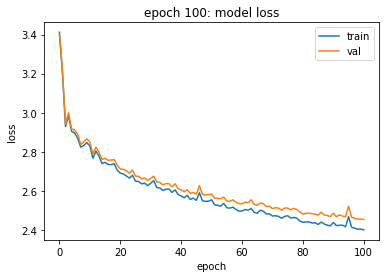

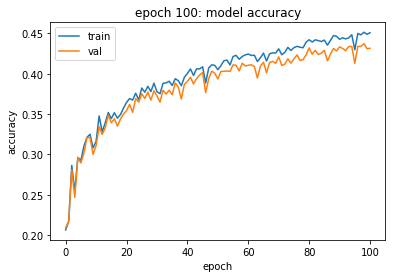



Epoch 101/500 ..............
Loss train:  2.415104628704656 
Loss val:  2.464941454823853 
Train accuracy:  0.4463 
Validation accuracy:  0.4327
Alpha:  0.001


Epoch 102/500 ..............
Loss train:  2.418231555879996 
Loss val:  2.470762300309767 
Train accuracy:  0.4482 
Validation accuracy:  0.4317
Alpha:  0.001


Epoch 103/500 ..............
Loss train:  2.395583159943834 
Loss val:  2.4482675759699597 
Train accuracy:  0.453975 
Validation accuracy:  0.4357
Alpha:  0.001


Epoch 104/500 ..............
Loss train:  2.400353229481091 
Loss val:  2.447561887990439 
Train accuracy:  0.452575 
Validation accuracy:  0.4416
Alpha:  0.001


Epoch 105/500 ..............
Loss train:  2.391742116291551 
Loss val:  2.4448058440503666 
Train accuracy:  0.4548 
Validation accuracy:  0.4395
Alpha:  0.001


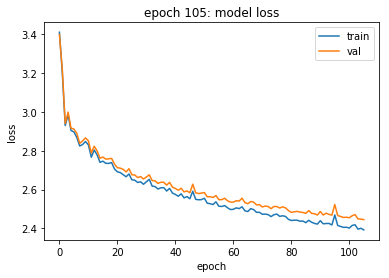

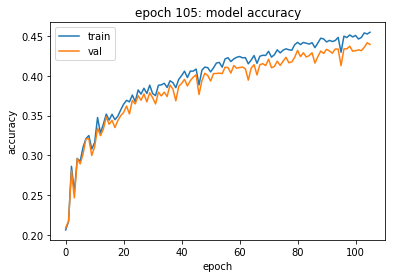



Epoch 106/500 ..............
Loss train:  2.386062295922437 
Loss val:  2.4370984911115663 
Train accuracy:  0.457225 
Validation accuracy:  0.4437
Alpha:  0.001


Epoch 107/500 ..............
Loss train:  2.3984060257512057 
Loss val:  2.4506471793534046 
Train accuracy:  0.4541 
Validation accuracy:  0.4403
Alpha:  0.001


Epoch 108/500 ..............
Loss train:  2.3951392759426233 
Loss val:  2.4521436884412133 
Train accuracy:  0.452 
Validation accuracy:  0.4359
Alpha:  0.001


Epoch 109/500 ..............
Loss train:  2.3915373063024057 
Loss val:  2.4475265202501495 
Train accuracy:  0.453225 
Validation accuracy:  0.4345
Alpha:  0.001


Epoch 110/500 ..............
Loss train:  2.392285222325897 
Loss val:  2.4487975106990425 
Train accuracy:  0.452325 
Validation accuracy:  0.4328
Alpha:  0.001


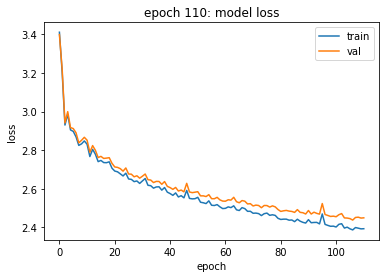

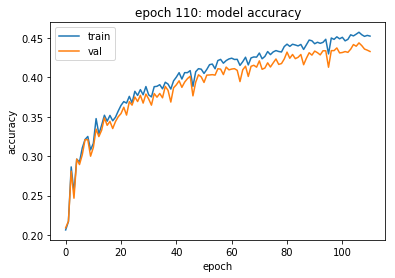



Epoch 111/500 ..............
Loss train:  2.385159846198472 
Loss val:  2.4388538314262944 
Train accuracy:  0.458225 
Validation accuracy:  0.4443
Alpha:  0.001


Epoch 112/500 ..............
Loss train:  2.405083133385925 
Loss val:  2.4559567010256242 
Train accuracy:  0.44895 
Validation accuracy:  0.4336
Alpha:  0.001


Epoch 113/500 ..............
Loss train:  2.382942832183825 
Loss val:  2.4390199389793095 
Train accuracy:  0.458 
Validation accuracy:  0.4403
Alpha:  0.001


Epoch 114/500 ..............
Loss train:  2.378608663064484 
Loss val:  2.430406597827041 
Train accuracy:  0.4573 
Validation accuracy:  0.4424
Alpha:  0.001


Epoch 115/500 ..............
Loss train:  2.3810050836187058 
Loss val:  2.4330145047462013 
Train accuracy:  0.4567 
Validation accuracy:  0.4393
Alpha:  0.001


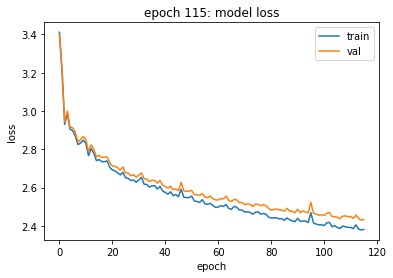

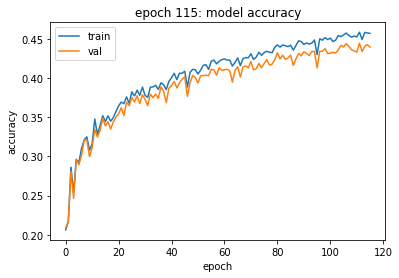



Epoch 116/500 ..............
Loss train:  2.367545850244555 
Loss val:  2.4230405976681784 
Train accuracy:  0.459825 
Validation accuracy:  0.4443
Alpha:  0.001


Epoch 117/500 ..............
Loss train:  2.3711028909614003 
Loss val:  2.427027533588513 
Train accuracy:  0.462075 
Validation accuracy:  0.4484
Alpha:  0.001


Epoch 118/500 ..............
Loss train:  2.3714675493107578 
Loss val:  2.428962005864705 
Train accuracy:  0.46135 
Validation accuracy:  0.4443
Alpha:  0.001


Epoch 119/500 ..............
Loss train:  2.385317986854297 
Loss val:  2.440508645549629 
Train accuracy:  0.4558 
Validation accuracy:  0.4427
Alpha:  0.001


Epoch 120/500 ..............
Loss train:  2.3629586849944113 
Loss val:  2.421293322899788 
Train accuracy:  0.462675 
Validation accuracy:  0.4496
Alpha:  0.001


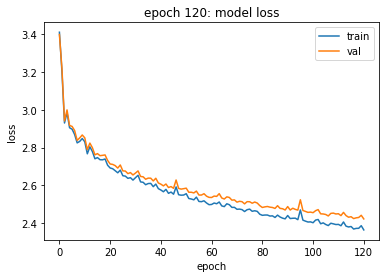

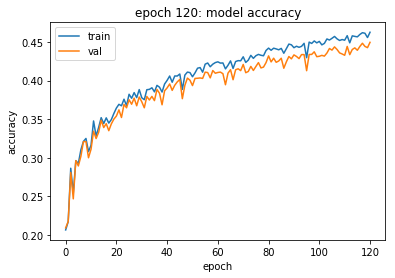



Epoch 121/500 ..............
Loss train:  2.3938947058390108 
Loss val:  2.4457811635001736 
Train accuracy:  0.45275 
Validation accuracy:  0.4377
Alpha:  0.001


Epoch 122/500 ..............
Loss train:  2.3634793585803773 
Loss val:  2.4204294930961305 
Train accuracy:  0.46355 
Validation accuracy:  0.4489
Alpha:  0.001


Epoch 123/500 ..............
Loss train:  2.3572828806271753 
Loss val:  2.4154491637112776 
Train accuracy:  0.46205 
Validation accuracy:  0.4436
Alpha:  0.001


Epoch 124/500 ..............
Loss train:  2.3655952325071916 
Loss val:  2.4223093009765986 
Train accuracy:  0.463525 
Validation accuracy:  0.4472
Alpha:  0.001


Epoch 125/500 ..............
Loss train:  2.3835206343301296 
Loss val:  2.4470667210283876 
Train accuracy:  0.454 
Validation accuracy:  0.4315
Alpha:  0.001


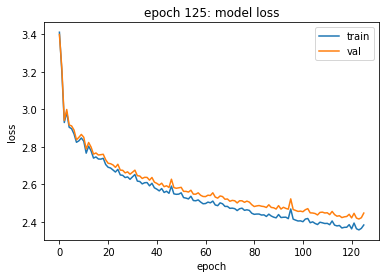

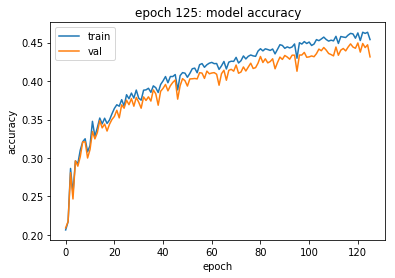



Epoch 126/500 ..............
Loss train:  2.354179959991015 
Loss val:  2.412477090861788 
Train accuracy:  0.4653 
Validation accuracy:  0.4503
Alpha:  0.001


Epoch 127/500 ..............
Loss train:  2.357603246220477 
Loss val:  2.4161723054289874 
Train accuracy:  0.464125 
Validation accuracy:  0.4507
Alpha:  0.001


Epoch 128/500 ..............
Loss train:  2.3640206959630676 
Loss val:  2.4194156576404198 
Train accuracy:  0.461425 
Validation accuracy:  0.4455
Alpha:  0.001


Epoch 129/500 ..............
Loss train:  2.355305718155034 
Loss val:  2.41373008394315 
Train accuracy:  0.466525 
Validation accuracy:  0.4512
Alpha:  0.001


Epoch 130/500 ..............
Loss train:  2.346810831183907 
Loss val:  2.4079350897547904 
Train accuracy:  0.468275 
Validation accuracy:  0.4486
Alpha:  0.001


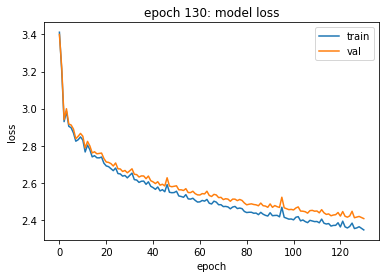

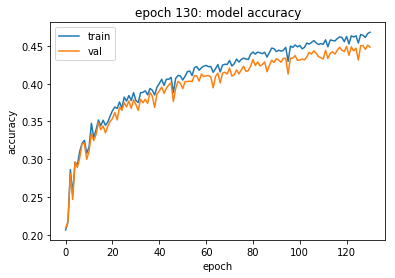



Epoch 131/500 ..............
Loss train:  2.3563426450505345 
Loss val:  2.4121946594853605 
Train accuracy:  0.462575 
Validation accuracy:  0.4474
Alpha:  0.001


Epoch 132/500 ..............
Loss train:  2.3496491607539407 
Loss val:  2.41070763636516 
Train accuracy:  0.46785 
Validation accuracy:  0.4512
Alpha:  0.001


Epoch 133/500 ..............
Loss train:  2.3522284735716794 
Loss val:  2.4158067929052627 
Train accuracy:  0.468275 
Validation accuracy:  0.4488
Alpha:  0.001


Epoch 134/500 ..............
Loss train:  2.339603129894055 
Loss val:  2.401122584292496 
Train accuracy:  0.46765 
Validation accuracy:  0.4474
Alpha:  0.001


Epoch 135/500 ..............
Loss train:  2.3408183788971817 
Loss val:  2.4042957174839676 
Train accuracy:  0.471575 
Validation accuracy:  0.4504
Alpha:  0.001


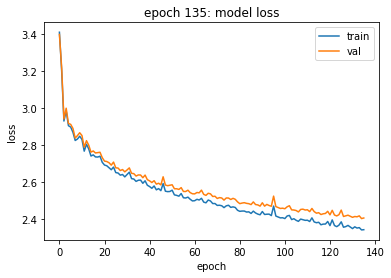

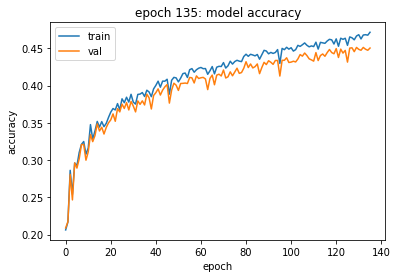



Epoch 136/500 ..............
Loss train:  2.355024123742715 
Loss val:  2.416207392682093 
Train accuracy:  0.464375 
Validation accuracy:  0.4471
Alpha:  0.001


Epoch 137/500 ..............
Loss train:  2.342654916864759 
Loss val:  2.4073022775209494 
Train accuracy:  0.4694 
Validation accuracy:  0.4467
Alpha:  0.001


Epoch 138/500 ..............
Loss train:  2.3624999888776594 
Loss val:  2.4296846361638216 
Train accuracy:  0.464 
Validation accuracy:  0.444
Alpha:  0.001


Epoch 139/500 ..............
Loss train:  2.3619286721576485 
Loss val:  2.4267875789090154 
Train accuracy:  0.457225 
Validation accuracy:  0.4378
Alpha:  0.001


Epoch 140/500 ..............
Loss train:  2.345710605554281 
Loss val:  2.408589929371705 
Train accuracy:  0.46775 
Validation accuracy:  0.4502
Alpha:  0.001


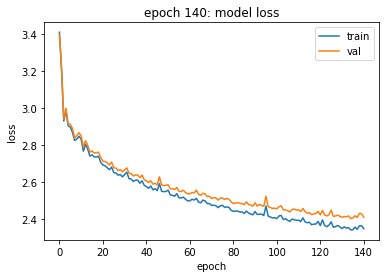

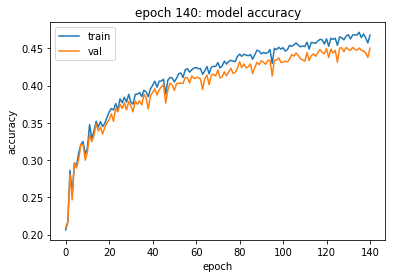



Epoch 141/500 ..............
Loss train:  2.33244554231028 
Loss val:  2.3964108151117847 
Train accuracy:  0.471625 
Validation accuracy:  0.4514
Alpha:  0.001


Epoch 142/500 ..............
Loss train:  2.332302181466336 
Loss val:  2.3971744981835545 
Train accuracy:  0.470625 
Validation accuracy:  0.4498
Alpha:  0.001


Epoch 143/500 ..............
Loss train:  2.3370598092749955 
Loss val:  2.4064218316492907 
Train accuracy:  0.4678 
Validation accuracy:  0.4437
Alpha:  0.001


Epoch 144/500 ..............
Loss train:  2.340416238804785 
Loss val:  2.4040508501243356 
Train accuracy:  0.47075 
Validation accuracy:  0.4554
Alpha:  0.001


Epoch 145/500 ..............
Loss train:  2.3561803203489693 
Loss val:  2.418248058743781 
Train accuracy:  0.46275 
Validation accuracy:  0.4434
Alpha:  0.001


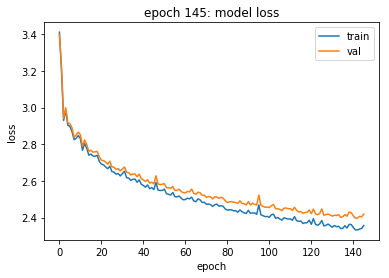

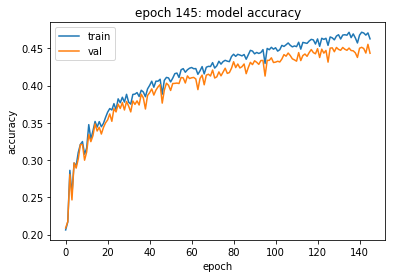



Epoch 146/500 ..............
Loss train:  2.3347956739337796 
Loss val:  2.4037255643367126 
Train accuracy:  0.4709 
Validation accuracy:  0.4522
Alpha:  0.001


Epoch 147/500 ..............
Loss train:  2.328062374301881 
Loss val:  2.3977338247737143 
Train accuracy:  0.4722 
Validation accuracy:  0.4501
Alpha:  0.001


Epoch 148/500 ..............
Loss train:  2.331052029043903 
Loss val:  2.4002241633695767 
Train accuracy:  0.47475 
Validation accuracy:  0.4535
Alpha:  0.001


Epoch 149/500 ..............
Loss train:  2.329535998493023 
Loss val:  2.3945582754757 
Train accuracy:  0.471875 
Validation accuracy:  0.454
Alpha:  0.001


Epoch 150/500 ..............
Loss train:  2.3279850876600876 
Loss val:  2.397941786790076 
Train accuracy:  0.47255 
Validation accuracy:  0.4527
Alpha:  0.001


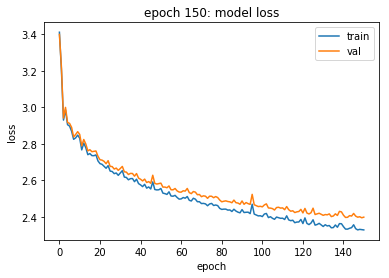

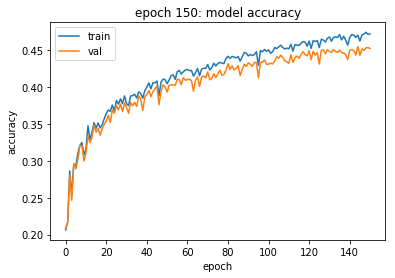



Epoch 151/500 ..............
Loss train:  2.3169304400032975 
Loss val:  2.3842495535383628 
Train accuracy:  0.4782 
Validation accuracy:  0.4599
Alpha:  0.001


Epoch 152/500 ..............
Loss train:  2.322121032372234 
Loss val:  2.391370033159809 
Train accuracy:  0.47495 
Validation accuracy:  0.4523
Alpha:  0.001


Epoch 153/500 ..............
Loss train:  2.312726712550629 
Loss val:  2.381773341929559 
Train accuracy:  0.477625 
Validation accuracy:  0.4561
Alpha:  0.001


Epoch 154/500 ..............
Loss train:  2.318055453509968 
Loss val:  2.3863941014399117 
Train accuracy:  0.475775 
Validation accuracy:  0.4563
Alpha:  0.001


Epoch 155/500 ..............
Loss train:  2.316764825683868 
Loss val:  2.385671572258236 
Train accuracy:  0.47685 
Validation accuracy:  0.4589
Alpha:  0.001


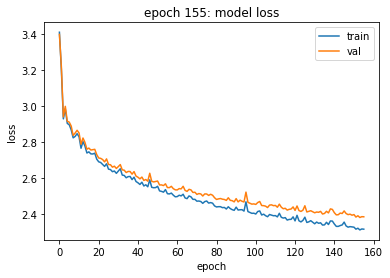

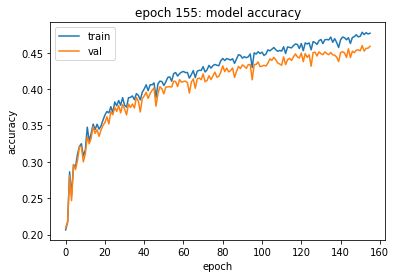



Epoch 156/500 ..............
Loss train:  2.3227812146523443 
Loss val:  2.3900769487961226 
Train accuracy:  0.47465 
Validation accuracy:  0.4573
Alpha:  0.001


Epoch 157/500 ..............
Loss train:  2.307295173830241 
Loss val:  2.377200059965252 
Train accuracy:  0.479225 
Validation accuracy:  0.4595
Alpha:  0.001


Epoch 158/500 ..............
Loss train:  2.3114572818860113 
Loss val:  2.380698223219862 
Train accuracy:  0.47815 
Validation accuracy:  0.4568
Alpha:  0.001


Epoch 159/500 ..............
Loss train:  2.3205511394661147 
Loss val:  2.3885631112278998 
Train accuracy:  0.475475 
Validation accuracy:  0.4528
Alpha:  0.001


Epoch 160/500 ..............
Loss train:  2.3195670861031665 
Loss val:  2.390133946795744 
Train accuracy:  0.4755 
Validation accuracy:  0.4532
Alpha:  0.001


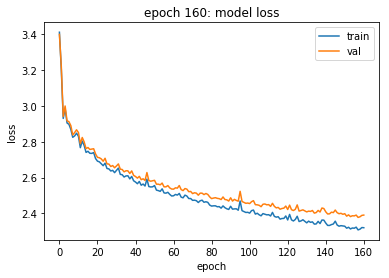

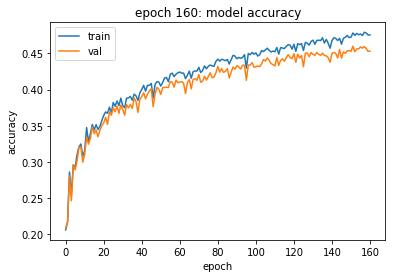



Epoch 161/500 ..............
Loss train:  2.3207434824784743 
Loss val:  2.3961167309089446 
Train accuracy:  0.47375 
Validation accuracy:  0.4473
Alpha:  0.001


Epoch 162/500 ..............
Loss train:  2.3195053137007076 
Loss val:  2.387555873645975 
Train accuracy:  0.475175 
Validation accuracy:  0.4608
Alpha:  0.001


Epoch 163/500 ..............
Loss train:  2.305782209553367 
Loss val:  2.3809453578608935 
Train accuracy:  0.480825 
Validation accuracy:  0.4565
Alpha:  0.001


Epoch 164/500 ..............
Loss train:  2.3005100212361906 
Loss val:  2.3730030319285356 
Train accuracy:  0.480825 
Validation accuracy:  0.464
Alpha:  0.001


Epoch 165/500 ..............
Loss train:  2.306258265406578 
Loss val:  2.376339516593015 
Train accuracy:  0.476975 
Validation accuracy:  0.4582
Alpha:  0.001


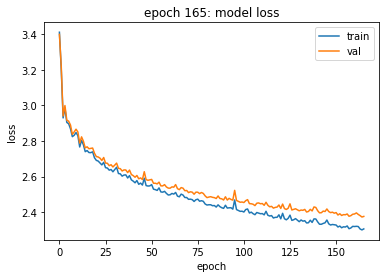

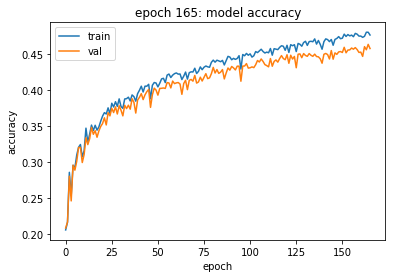



Epoch 166/500 ..............
Loss train:  2.3153813796429614 
Loss val:  2.3886035202642755 
Train accuracy:  0.475825 
Validation accuracy:  0.4605
Alpha:  0.001


Epoch 167/500 ..............
Loss train:  2.3079720117298144 
Loss val:  2.3844087834186842 
Train accuracy:  0.478475 
Validation accuracy:  0.456
Alpha:  0.001


Epoch 168/500 ..............
Loss train:  2.3023546644043784 
Loss val:  2.3808294556034633 
Train accuracy:  0.48065 
Validation accuracy:  0.4559
Alpha:  0.001


Epoch 169/500 ..............
Loss train:  2.3016173511684204 
Loss val:  2.3790681390300046 
Train accuracy:  0.48145 
Validation accuracy:  0.4602
Alpha:  0.001


Epoch 170/500 ..............
Loss train:  2.3028686877549998 
Loss val:  2.376524754026133 
Train accuracy:  0.47835 
Validation accuracy:  0.4552
Alpha:  0.001


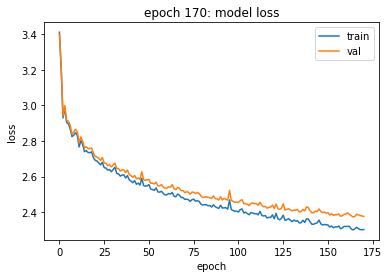

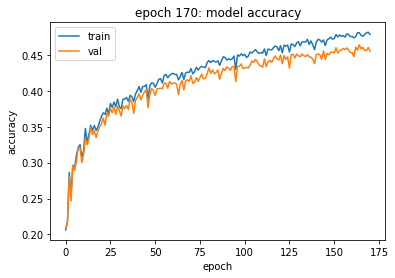



Epoch 171/500 ..............
Loss train:  2.307138631201073 
Loss val:  2.380991289159041 
Train accuracy:  0.47985 
Validation accuracy:  0.4576
Alpha:  0.001


Epoch 172/500 ..............
Loss train:  2.3021784036106574 
Loss val:  2.3741525159565096 
Train accuracy:  0.478975 
Validation accuracy:  0.4595
Alpha:  0.001


Epoch 173/500 ..............
Loss train:  2.293514542283468 
Loss val:  2.370356341023915 
Train accuracy:  0.480175 
Validation accuracy:  0.4571
Alpha:  0.001


Epoch 174/500 ..............
Loss train:  2.2960444359960874 
Loss val:  2.372022000938324 
Train accuracy:  0.478925 
Validation accuracy:  0.4583
Alpha:  0.001


Epoch 175/500 ..............
Loss train:  2.29337927504047 
Loss val:  2.3663954540158145 
Train accuracy:  0.4803 
Validation accuracy:  0.459
Alpha:  0.001


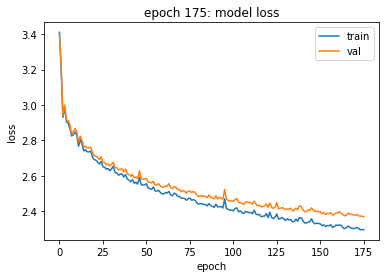

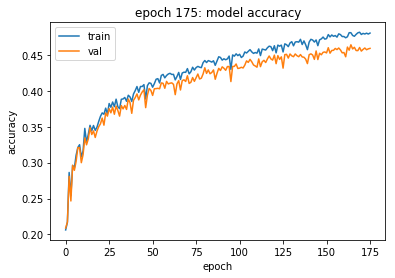



Epoch 176/500 ..............
Loss train:  2.298835452070988 
Loss val:  2.376372000082061 
Train accuracy:  0.47895 
Validation accuracy:  0.4551
Alpha:  0.001


Epoch 177/500 ..............
Loss train:  2.296412361725657 
Loss val:  2.3715967258445523 
Train accuracy:  0.481125 
Validation accuracy:  0.4593
Alpha:  0.001


Epoch 178/500 ..............
Loss train:  2.296840228379253 
Loss val:  2.3731027760909966 
Train accuracy:  0.479225 
Validation accuracy:  0.4582
Alpha:  0.001


Epoch 179/500 ..............
Loss train:  2.298575051573457 
Loss val:  2.377255818725484 
Train accuracy:  0.4808 
Validation accuracy:  0.4592
Alpha:  0.001


Epoch 180/500 ..............
Loss train:  2.3049478847879765 
Loss val:  2.385963023349196 
Train accuracy:  0.479875 
Validation accuracy:  0.4565
Alpha:  0.001


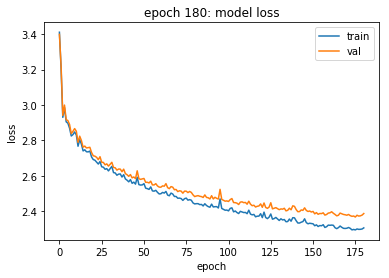

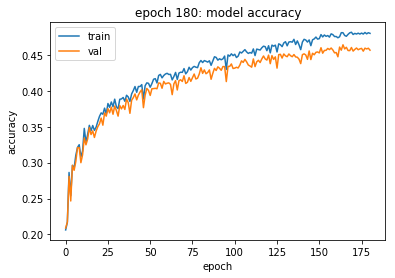



Epoch 181/500 ..............
Loss train:  2.298742812711893 
Loss val:  2.3754469516496766 
Train accuracy:  0.4791 
Validation accuracy:  0.4587
Alpha:  0.001


Epoch 182/500 ..............
Loss train:  2.2923067487276825 
Loss val:  2.3700093167891145 
Train accuracy:  0.4811 
Validation accuracy:  0.4545
Alpha:  0.001


Epoch 183/500 ..............
Loss train:  2.2809902633240804 
Loss val:  2.364447538662228 
Train accuracy:  0.487475 
Validation accuracy:  0.459
Alpha:  0.001


Epoch 184/500 ..............
Loss train:  2.272510629927822 
Loss val:  2.353882706673269 
Train accuracy:  0.486625 
Validation accuracy:  0.4633
Alpha:  0.001


Epoch 185/500 ..............
Loss train:  2.294582807652747 
Loss val:  2.3816778968257086 
Train accuracy:  0.477575 
Validation accuracy:  0.4515
Alpha:  0.001


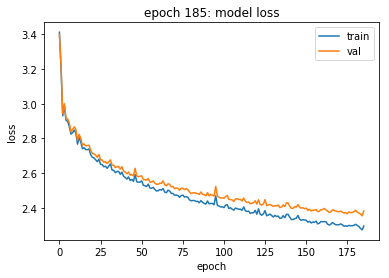

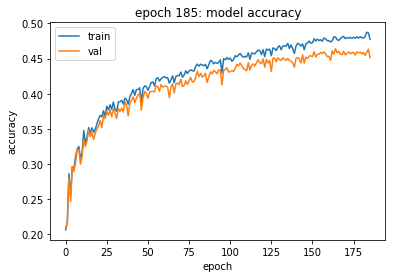



Epoch 186/500 ..............
Loss train:  2.2838322724546605 
Loss val:  2.365696013859456 
Train accuracy:  0.485425 
Validation accuracy:  0.4624
Alpha:  0.001


Epoch 187/500 ..............
Loss train:  2.2701980518276317 
Loss val:  2.3513850308192783 
Train accuracy:  0.4872 
Validation accuracy:  0.4648
Alpha:  0.001


Epoch 188/500 ..............
Loss train:  2.275339384963332 
Loss val:  2.3587070030014443 
Train accuracy:  0.48715 
Validation accuracy:  0.4614
Alpha:  0.001


Epoch 189/500 ..............
Loss train:  2.2842638828275517 
Loss val:  2.362038814216892 
Train accuracy:  0.48085 
Validation accuracy:  0.4619
Alpha:  0.001


Epoch 190/500 ..............
Loss train:  2.2725694679561177 
Loss val:  2.354984393508869 
Train accuracy:  0.486475 
Validation accuracy:  0.4594
Alpha:  0.001


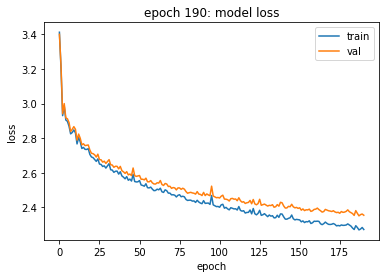

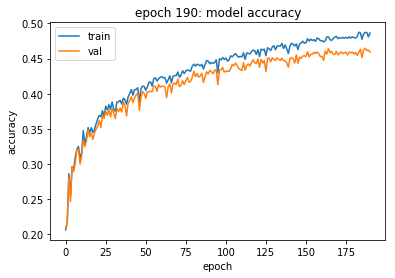



Epoch 191/500 ..............
Loss train:  2.2728428395843365 
Loss val:  2.3573677661784735 
Train accuracy:  0.489225 
Validation accuracy:  0.4612
Alpha:  0.001


Epoch 192/500 ..............
Loss train:  2.2799541604241016 
Loss val:  2.3598378762780063 
Train accuracy:  0.48625 
Validation accuracy:  0.4655
Alpha:  0.001


Epoch 193/500 ..............
Loss train:  2.2667156680582905 
Loss val:  2.3494391498494083 
Train accuracy:  0.489125 
Validation accuracy:  0.4672
Alpha:  0.001


Epoch 194/500 ..............
Loss train:  2.2763066828637557 
Loss val:  2.364885637066806 
Train accuracy:  0.4878 
Validation accuracy:  0.4615
Alpha:  0.001


Epoch 195/500 ..............
Loss train:  2.270159397913859 
Loss val:  2.35194175546472 
Train accuracy:  0.486475 
Validation accuracy:  0.4629
Alpha:  0.001


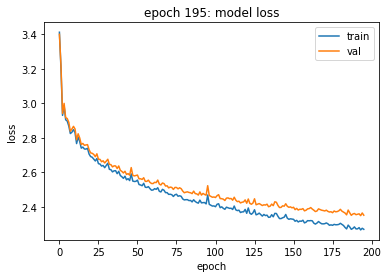

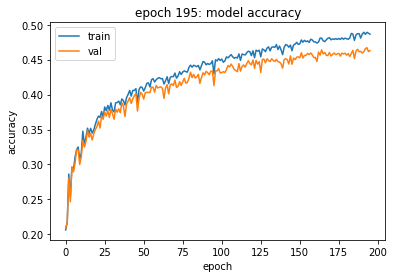



Epoch 196/500 ..............
Loss train:  2.263944715244709 
Loss val:  2.351151700881903 
Train accuracy:  0.489925 
Validation accuracy:  0.4603
Alpha:  0.001


Epoch 197/500 ..............
Loss train:  2.262191173724626 
Loss val:  2.3465430063706156 
Train accuracy:  0.489225 
Validation accuracy:  0.4663
Alpha:  0.001


Epoch 198/500 ..............
Loss train:  2.2631084527504237 
Loss val:  2.34751519826922 
Train accuracy:  0.489925 
Validation accuracy:  0.4667
Alpha:  0.001


Epoch 199/500 ..............
Loss train:  2.2783454038241917 
Loss val:  2.3616864035137732 
Train accuracy:  0.49055 
Validation accuracy:  0.4682
Alpha:  0.001


Epoch 200/500 ..............
Loss train:  2.270018924772506 
Loss val:  2.3601400914383937 
Train accuracy:  0.489325 
Validation accuracy:  0.4583
Alpha:  0.001


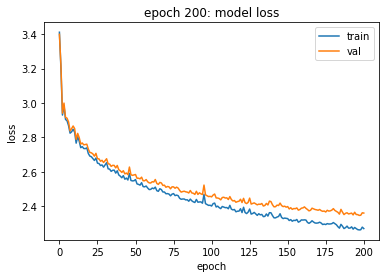

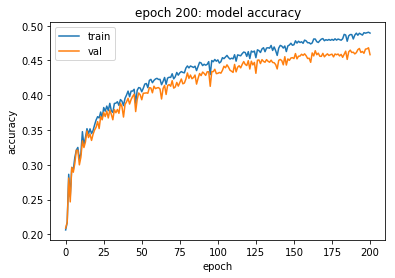



Epoch 201/500 ..............
Loss train:  2.257565920830098 
Loss val:  2.3462161745751757 
Train accuracy:  0.490875 
Validation accuracy:  0.4663
Alpha:  0.001


Epoch 202/500 ..............
Loss train:  2.264058203746298 
Loss val:  2.3503546176942436 
Train accuracy:  0.491475 
Validation accuracy:  0.4678
Alpha:  0.001


Epoch 203/500 ..............
Loss train:  2.2721719625049506 
Loss val:  2.360284263970424 
Train accuracy:  0.4898 
Validation accuracy:  0.4617
Alpha:  0.001


Epoch 204/500 ..............
Loss train:  2.2647496217667484 
Loss val:  2.35390351995172 
Train accuracy:  0.490125 
Validation accuracy:  0.4638
Alpha:  0.001


Epoch 205/500 ..............
Loss train:  2.265379453536416 
Loss val:  2.3515684006131736 
Train accuracy:  0.4865 
Validation accuracy:  0.4685
Alpha:  0.001


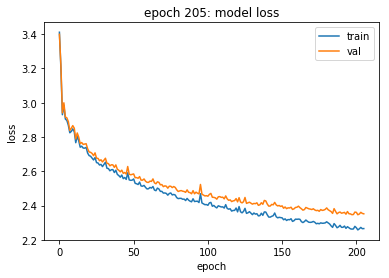

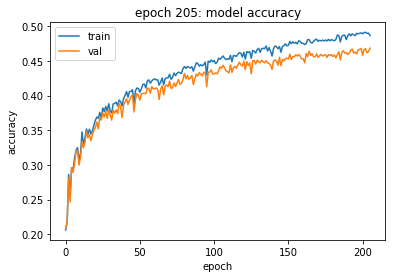



Epoch 206/500 ..............
Loss train:  2.2605274507073467 
Loss val:  2.3493279294991876 
Train accuracy:  0.489825 
Validation accuracy:  0.4681
Alpha:  0.001


Epoch 207/500 ..............
Loss train:  2.253758328369146 
Loss val:  2.3437178610082343 
Train accuracy:  0.49575 
Validation accuracy:  0.4687
Alpha:  0.001


Epoch 208/500 ..............
Loss train:  2.2658598677670483 
Loss val:  2.353615466412895 
Train accuracy:  0.487225 
Validation accuracy:  0.464
Alpha:  0.001


Epoch 209/500 ..............
Loss train:  2.2626399070607714 
Loss val:  2.3555186268552823 
Train accuracy:  0.493 
Validation accuracy:  0.4637
Alpha:  0.001


Epoch 210/500 ..............
Loss train:  2.2529785417459784 
Loss val:  2.34452498522835 
Train accuracy:  0.491925 
Validation accuracy:  0.4651
Alpha:  0.001


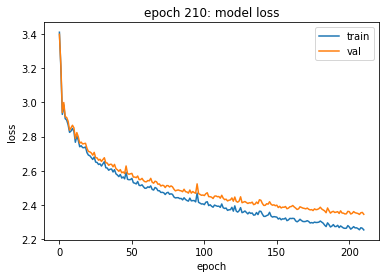

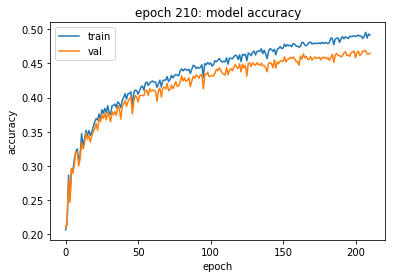



Epoch 211/500 ..............
Loss train:  2.2602863883636033 
Loss val:  2.353358104350963 
Train accuracy:  0.490075 
Validation accuracy:  0.465
Alpha:  0.001


Epoch 212/500 ..............
Loss train:  2.2471100140057985 
Loss val:  2.3430076612748687 
Train accuracy:  0.495725 
Validation accuracy:  0.4672
Alpha:  0.001


Epoch 213/500 ..............
Loss train:  2.252561559592708 
Loss val:  2.3454005412953642 
Train accuracy:  0.493225 
Validation accuracy:  0.4623
Alpha:  0.001


Epoch 214/500 ..............
Loss train:  2.2507684859810317 
Loss val:  2.340885319023551 
Train accuracy:  0.49165 
Validation accuracy:  0.467
Alpha:  0.001


Epoch 215/500 ..............
Loss train:  2.24998933957033 
Loss val:  2.3445140058727993 
Train accuracy:  0.4952 
Validation accuracy:  0.4715
Alpha:  0.001


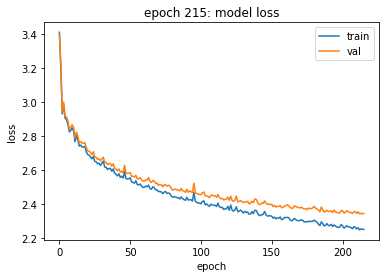

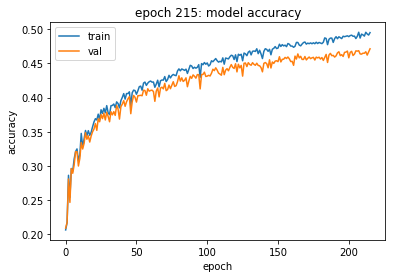



Epoch 216/500 ..............
Loss train:  2.2498661711626675 
Loss val:  2.3425768210900606 
Train accuracy:  0.4945 
Validation accuracy:  0.4681
Alpha:  0.001


Epoch 217/500 ..............
Loss train:  2.2534988446718724 
Loss val:  2.349212456041816 
Train accuracy:  0.4949 
Validation accuracy:  0.4709
Alpha:  0.001


Epoch 218/500 ..............
Loss train:  2.23689751661312 
Loss val:  2.3318859598467854 
Train accuracy:  0.49775 
Validation accuracy:  0.4696
Alpha:  0.001


Epoch 219/500 ..............
Loss train:  2.2392141077307137 
Loss val:  2.3368161769877256 
Train accuracy:  0.4981 
Validation accuracy:  0.4673
Alpha:  0.001


Epoch 220/500 ..............
Loss train:  2.246420622561008 
Loss val:  2.3438332809026416 
Train accuracy:  0.493125 
Validation accuracy:  0.4664
Alpha:  0.001


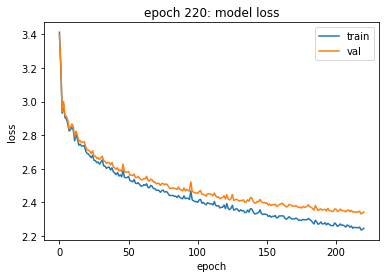

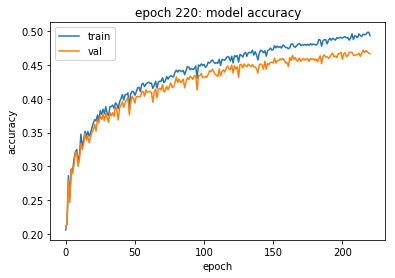



Epoch 221/500 ..............
Loss train:  2.2381338766757266 
Loss val:  2.338021006931249 
Train accuracy:  0.4979 
Validation accuracy:  0.4707
Alpha:  0.001


Epoch 222/500 ..............
Loss train:  2.233542762503862 
Loss val:  2.3302210035804705 
Train accuracy:  0.501225 
Validation accuracy:  0.4746
Alpha:  0.001


Epoch 223/500 ..............
Loss train:  2.263969163478494 
Loss val:  2.3667336170025357 
Train accuracy:  0.490425 
Validation accuracy:  0.4609
Alpha:  0.001


Epoch 224/500 ..............
Loss train:  2.2360177077902335 
Loss val:  2.338907971192723 
Train accuracy:  0.498825 
Validation accuracy:  0.4705
Alpha:  0.001


Epoch 225/500 ..............
Loss train:  2.2442461570390395 
Loss val:  2.3424484994792647 
Train accuracy:  0.49295 
Validation accuracy:  0.467
Alpha:  0.001


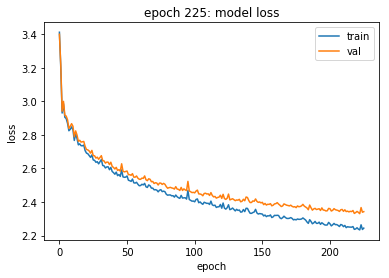

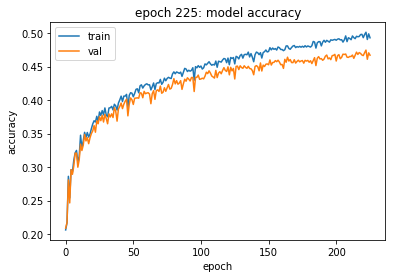



Epoch 226/500 ..............
Loss train:  2.2340926142463844 
Loss val:  2.3336836996098826 
Train accuracy:  0.499375 
Validation accuracy:  0.4718
Alpha:  0.001


Epoch 227/500 ..............
Loss train:  2.2541884779041697 
Loss val:  2.355263898943486 
Train accuracy:  0.497175 
Validation accuracy:  0.4715
Alpha:  0.001


Epoch 228/500 ..............
Loss train:  2.2361739716797 
Loss val:  2.334979707683062 
Train accuracy:  0.4977 
Validation accuracy:  0.4634
Alpha:  0.001


Epoch 229/500 ..............
Loss train:  2.2306821627977826 
Loss val:  2.3304619433786433 
Train accuracy:  0.49735 
Validation accuracy:  0.4671
Alpha:  0.001


Epoch 230/500 ..............
Loss train:  2.236368397490014 
Loss val:  2.3404427878852316 
Train accuracy:  0.498475 
Validation accuracy:  0.4685
Alpha:  0.001


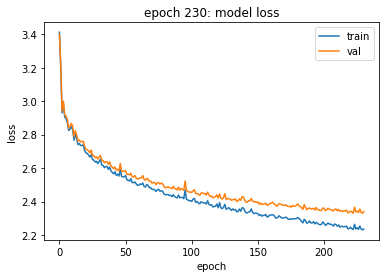

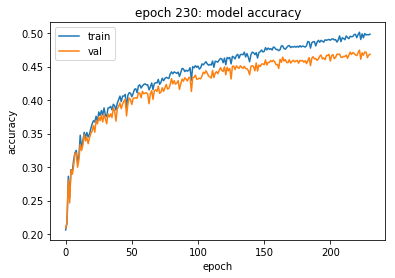



Epoch 231/500 ..............
Loss train:  2.243245451808872 
Loss val:  2.345401277016814 
Train accuracy:  0.496975 
Validation accuracy:  0.4666
Alpha:  0.001


Epoch 232/500 ..............
Loss train:  2.2289702377134084 
Loss val:  2.332772863421715 
Train accuracy:  0.502075 
Validation accuracy:  0.4712
Alpha:  0.001


Epoch 233/500 ..............
Loss train:  2.2495104783160054 
Loss val:  2.357970452183153 
Train accuracy:  0.496025 
Validation accuracy:  0.4639
Alpha:  0.001


Epoch 234/500 ..............
Loss train:  2.2339232018555504 
Loss val:  2.3362863903913147 
Train accuracy:  0.49985 
Validation accuracy:  0.4674
Alpha:  0.001


Epoch 235/500 ..............
Loss train:  2.2300046330359162 
Loss val:  2.3292331971589206 
Train accuracy:  0.498525 
Validation accuracy:  0.4698
Alpha:  0.001


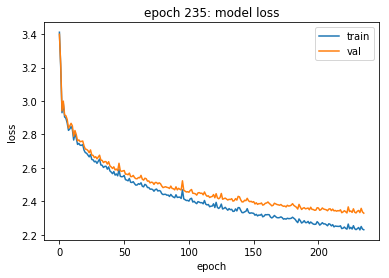

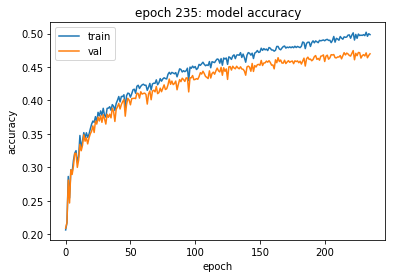



Epoch 236/500 ..............
Loss train:  2.2343460858406896 
Loss val:  2.3396307737757507 
Train accuracy:  0.501625 
Validation accuracy:  0.4678
Alpha:  0.001


Epoch 237/500 ..............
Loss train:  2.2199043016479276 
Loss val:  2.3231269868678677 
Train accuracy:  0.502225 
Validation accuracy:  0.4735
Alpha:  0.001


Epoch 238/500 ..............
Loss train:  2.217059572326578 
Loss val:  2.319743555914708 
Train accuracy:  0.50515 
Validation accuracy:  0.4738
Alpha:  0.001


Epoch 239/500 ..............
Loss train:  2.2231622754281113 
Loss val:  2.3267853306813873 
Train accuracy:  0.501525 
Validation accuracy:  0.4721
Alpha:  0.001


Epoch 240/500 ..............
Loss train:  2.223734165233103 
Loss val:  2.3275884519549797 
Train accuracy:  0.50295 
Validation accuracy:  0.4718
Alpha:  0.001


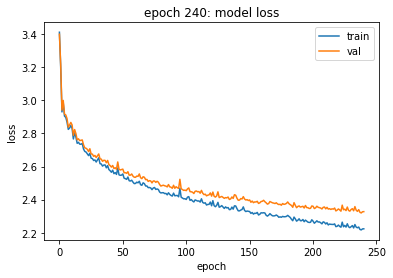

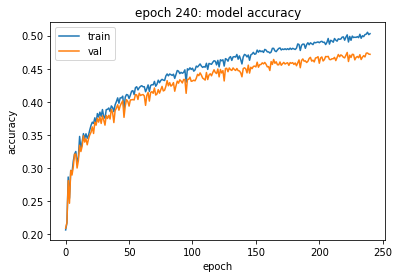



Epoch 241/500 ..............
Loss train:  2.224450748126665 
Loss val:  2.3265545019744196 
Train accuracy:  0.5016 
Validation accuracy:  0.4716
Alpha:  0.001


Epoch 242/500 ..............
Loss train:  2.220694581759125 
Loss val:  2.323495020766656 
Train accuracy:  0.50485 
Validation accuracy:  0.4732
Alpha:  0.001


Epoch 243/500 ..............
Loss train:  2.228738058196761 
Loss val:  2.337803750718703 
Train accuracy:  0.50035 
Validation accuracy:  0.4652
Alpha:  0.001


Epoch 244/500 ..............
Loss train:  2.223455935084548 
Loss val:  2.3320660018127732 
Train accuracy:  0.502525 
Validation accuracy:  0.4678
Alpha:  0.001


Epoch 245/500 ..............
Loss train:  2.251447376931962 
Loss val:  2.3533807591129103 
Train accuracy:  0.49045 
Validation accuracy:  0.4621
Alpha:  0.001


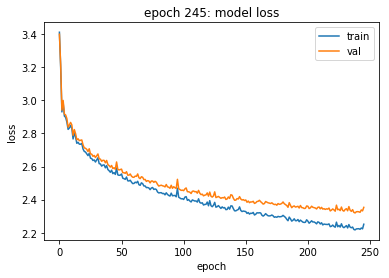

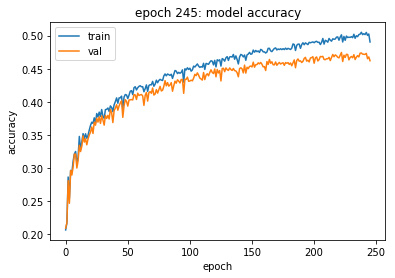



Epoch 246/500 ..............
Loss train:  2.223040993597243 
Loss val:  2.3357176748962 
Train accuracy:  0.502175 
Validation accuracy:  0.4635
Alpha:  0.001


Epoch 247/500 ..............
Loss train:  2.215020231550515 
Loss val:  2.322841734777674 
Train accuracy:  0.505175 
Validation accuracy:  0.4794
Alpha:  0.001


Epoch 248/500 ..............
Loss train:  2.2108238745696838 
Loss val:  2.319894664232732 
Train accuracy:  0.5056 
Validation accuracy:  0.4758
Alpha:  0.001


Epoch 249/500 ..............
Loss train:  2.2211021554394454 
Loss val:  2.3325537007426353 
Train accuracy:  0.5042 
Validation accuracy:  0.4727
Alpha:  0.001


Epoch 250/500 ..............
Loss train:  2.215728926011086 
Loss val:  2.3251532659116116 
Train accuracy:  0.505175 
Validation accuracy:  0.4718
Alpha:  0.001


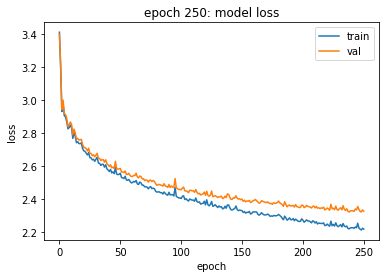

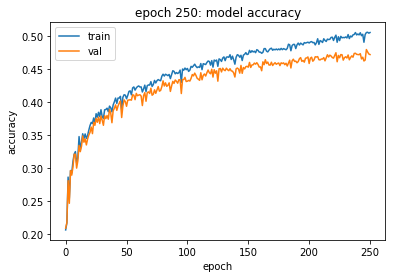



Epoch 251/500 ..............
Loss train:  2.216609560885846 
Loss val:  2.3235467753525456 
Train accuracy:  0.500625 
Validation accuracy:  0.4697
Alpha:  0.001


Epoch 252/500 ..............
Loss train:  2.2203630477052108 
Loss val:  2.3301769264525665 
Train accuracy:  0.50255 
Validation accuracy:  0.4715
Alpha:  0.001


Epoch 253/500 ..............
Loss train:  2.2009612169090977 
Loss val:  2.3118671362823733 
Train accuracy:  0.5066 
Validation accuracy:  0.4751
Alpha:  0.001


Epoch 254/500 ..............
Loss train:  2.207487049845421 
Loss val:  2.319681816097424 
Train accuracy:  0.509075 
Validation accuracy:  0.4783
Alpha:  0.001


Epoch 255/500 ..............
Loss train:  2.200132738201698 
Loss val:  2.315541867058976 
Train accuracy:  0.5093 
Validation accuracy:  0.4773
Alpha:  0.001


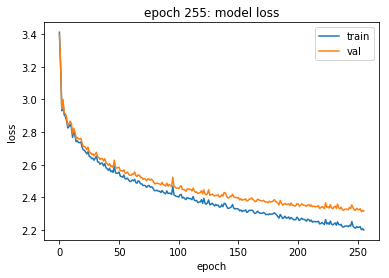

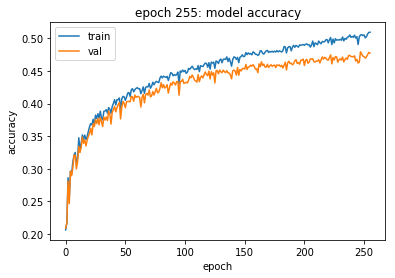



Epoch 256/500 ..............
Loss train:  2.2157858839225084 
Loss val:  2.326656001926678 
Train accuracy:  0.499075 
Validation accuracy:  0.467
Alpha:  0.001


Epoch 257/500 ..............
Loss train:  2.197566108800755 
Loss val:  2.3111200230951896 
Train accuracy:  0.50985 
Validation accuracy:  0.4751
Alpha:  0.001


Epoch 258/500 ..............
Loss train:  2.223504585142586 
Loss val:  2.335930301797994 
Train accuracy:  0.5032 
Validation accuracy:  0.4696
Alpha:  0.001


Epoch 259/500 ..............
Loss train:  2.198262645378736 
Loss val:  2.307761703992347 
Train accuracy:  0.50765 
Validation accuracy:  0.4751
Alpha:  0.001


Epoch 260/500 ..............
Loss train:  2.1964636538226485 
Loss val:  2.3097448454436025 
Train accuracy:  0.51005 
Validation accuracy:  0.4763
Alpha:  0.001


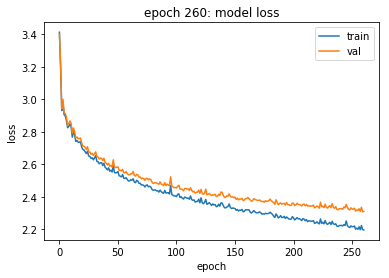

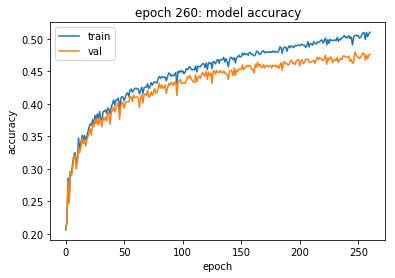



Epoch 261/500 ..............
Loss train:  2.2144717507656275 
Loss val:  2.3298817077329947 
Train accuracy:  0.507125 
Validation accuracy:  0.4776
Alpha:  0.001


Epoch 262/500 ..............
Loss train:  2.2070655187314285 
Loss val:  2.3214530087689935 
Train accuracy:  0.508 
Validation accuracy:  0.475
Alpha:  0.001


Epoch 263/500 ..............
Loss train:  2.2407214071177037 
Loss val:  2.353541295402504 
Train accuracy:  0.499175 
Validation accuracy:  0.4686
Alpha:  0.001


Epoch 264/500 ..............
Loss train:  2.1967818772030197 
Loss val:  2.3137357572895225 
Train accuracy:  0.510725 
Validation accuracy:  0.4734
Alpha:  0.001


Epoch 265/500 ..............
Loss train:  2.22413306381888 
Loss val:  2.3367699349683817 
Train accuracy:  0.502775 
Validation accuracy:  0.4718
Alpha:  0.001


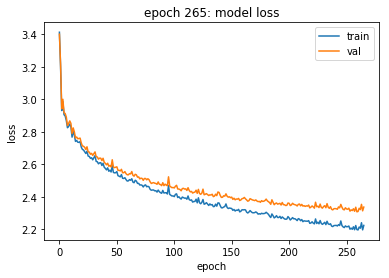

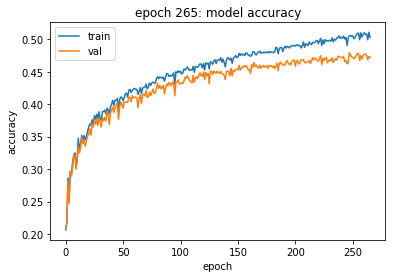



Epoch 266/500 ..............
Loss train:  2.195217084335578 
Loss val:  2.309487366843017 
Train accuracy:  0.50845 
Validation accuracy:  0.4784
Alpha:  0.001


Epoch 267/500 ..............
Loss train:  2.2036191193233114 
Loss val:  2.3163764113076457 
Train accuracy:  0.50765 
Validation accuracy:  0.4811
Alpha:  0.001


Epoch 268/500 ..............
Loss train:  2.2045281955997766 
Loss val:  2.3154846448444633 
Train accuracy:  0.502175 
Validation accuracy:  0.4751
Alpha:  0.001


Epoch 269/500 ..............
Loss train:  2.2217896918440148 
Loss val:  2.3342882719667317 
Train accuracy:  0.503825 
Validation accuracy:  0.4758
Alpha:  0.001


Epoch 270/500 ..............
Loss train:  2.1967869086101053 
Loss val:  2.3116873266162186 
Train accuracy:  0.50885 
Validation accuracy:  0.474
Alpha:  0.001


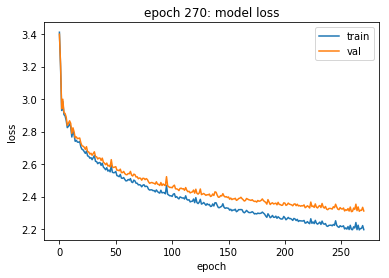

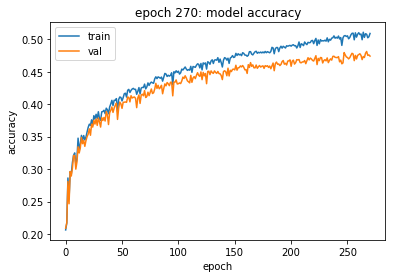



Epoch 271/500 ..............
Loss train:  2.2272948402126684 
Loss val:  2.347765789375596 
Train accuracy:  0.4963 
Validation accuracy:  0.4613
Alpha:  0.001


Epoch 272/500 ..............
Loss train:  2.1943257481474383 
Loss val:  2.308646099554649 
Train accuracy:  0.51155 
Validation accuracy:  0.4793
Alpha:  0.001


Epoch 273/500 ..............
Loss train:  2.1877637102147647 
Loss val:  2.307245358477475 
Train accuracy:  0.51015 
Validation accuracy:  0.4759
Alpha:  0.001


Epoch 274/500 ..............
Loss train:  2.2030530142498357 
Loss val:  2.3207521013766086 
Train accuracy:  0.507625 
Validation accuracy:  0.4716
Alpha:  0.001


Epoch 275/500 ..............
Loss train:  2.200032886250833 
Loss val:  2.321305844282494 
Train accuracy:  0.505625 
Validation accuracy:  0.4712
Alpha:  0.001


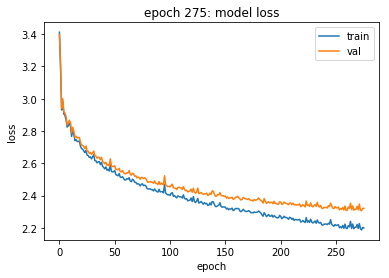

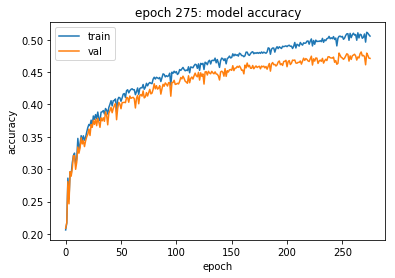



Epoch 276/500 ..............
Loss train:  2.1946262211234693 
Loss val:  2.3153674778830076 
Train accuracy:  0.512825 
Validation accuracy:  0.4839
Alpha:  0.001


Epoch 277/500 ..............
Loss train:  2.2090703113354517 
Loss val:  2.3329773585464655 
Train accuracy:  0.50235 
Validation accuracy:  0.4637
Alpha:  0.001


Epoch 278/500 ..............
Loss train:  2.192439359227351 
Loss val:  2.309798209500428 
Train accuracy:  0.510175 
Validation accuracy:  0.4805
Alpha:  0.001


Epoch 279/500 ..............
Loss train:  2.198358359429153 
Loss val:  2.314354194963445 
Train accuracy:  0.509175 
Validation accuracy:  0.4764
Alpha:  0.001


Epoch 280/500 ..............
Loss train:  2.1998744680257127 
Loss val:  2.3183331309899082 
Train accuracy:  0.502725 
Validation accuracy:  0.4726
Alpha:  0.001


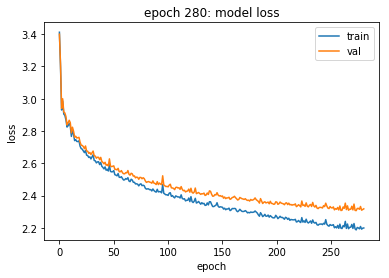

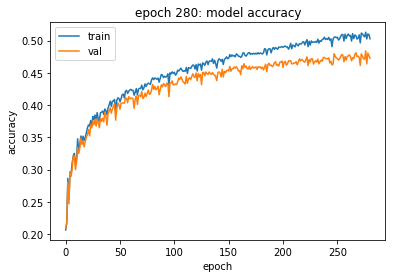



Epoch 281/500 ..............
Loss train:  2.1885918546264107 
Loss val:  2.3138022367753894 
Train accuracy:  0.51105 
Validation accuracy:  0.4715
Alpha:  0.001


Epoch 282/500 ..............
Loss train:  2.2011953239930167 
Loss val:  2.326754927192944 
Train accuracy:  0.511075 
Validation accuracy:  0.4787
Alpha:  0.001


Epoch 283/500 ..............
Loss train:  2.1876790654032257 
Loss val:  2.3100025309697414 
Train accuracy:  0.511975 
Validation accuracy:  0.4754
Alpha:  0.001


Epoch 284/500 ..............
Loss train:  2.18946159972677 
Loss val:  2.3078660901339165 
Train accuracy:  0.508 
Validation accuracy:  0.4737
Alpha:  0.001


Epoch 285/500 ..............
Loss train:  2.2004906439320036 
Loss val:  2.3279400821685234 
Train accuracy:  0.507 
Validation accuracy:  0.4683
Alpha:  0.001


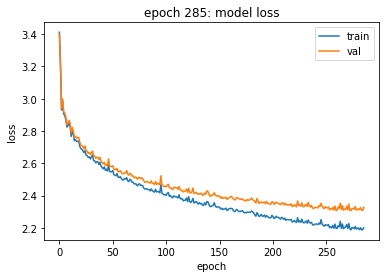

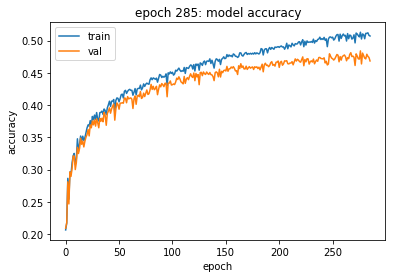



Epoch 286/500 ..............
Loss train:  2.1784048555190885 
Loss val:  2.301222256597137 
Train accuracy:  0.514975 
Validation accuracy:  0.4824
Alpha:  0.001


Epoch 287/500 ..............
Loss train:  2.1735235978499663 
Loss val:  2.2944288418595296 
Train accuracy:  0.515175 
Validation accuracy:  0.48
Alpha:  0.001


Epoch 288/500 ..............
Loss train:  2.193673946575339 
Loss val:  2.3213756458974535 
Train accuracy:  0.510625 
Validation accuracy:  0.4759
Alpha:  0.001


Epoch 289/500 ..............
Loss train:  2.1750702318773607 
Loss val:  2.3003030577685197 
Train accuracy:  0.515775 
Validation accuracy:  0.4778
Alpha:  0.001


Epoch 290/500 ..............
Loss train:  2.1684402709183597 
Loss val:  2.29250183589926 
Train accuracy:  0.519425 
Validation accuracy:  0.483
Alpha:  0.001


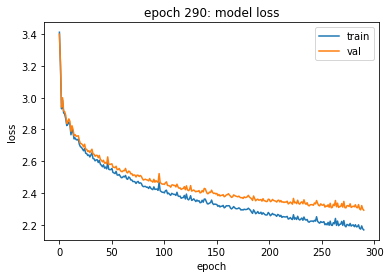

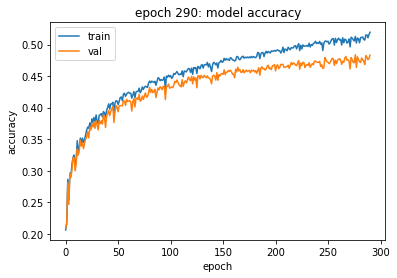



Epoch 291/500 ..............
Loss train:  2.1876923820449905 
Loss val:  2.313555217146099 
Train accuracy:  0.5127 
Validation accuracy:  0.4728
Alpha:  0.001


Epoch 292/500 ..............
Loss train:  2.1840930774891305 
Loss val:  2.306816857090251 
Train accuracy:  0.515325 
Validation accuracy:  0.4806
Alpha:  0.001


Epoch 293/500 ..............
Loss train:  2.1882397657932233 
Loss val:  2.3138707414880164 
Train accuracy:  0.51145 
Validation accuracy:  0.4725
Alpha:  0.001


Epoch 294/500 ..............
Loss train:  2.1719373081234035 
Loss val:  2.301376185568245 
Train accuracy:  0.518625 
Validation accuracy:  0.4813
Alpha:  0.001


Epoch 295/500 ..............
Loss train:  2.17910603265244 
Loss val:  2.3043104339553344 
Train accuracy:  0.51645 
Validation accuracy:  0.4852
Alpha:  0.001


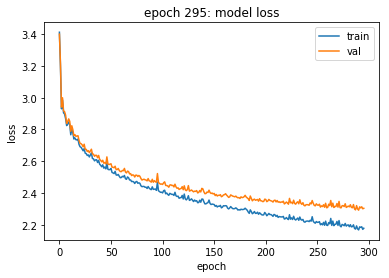

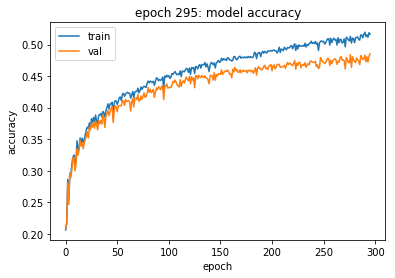



Epoch 296/500 ..............
Loss train:  2.1630353531274547 
Loss val:  2.2899780581706195 
Train accuracy:  0.520125 
Validation accuracy:  0.4834
Alpha:  0.001


Epoch 297/500 ..............
Loss train:  2.1840253096696935 
Loss val:  2.3137093310089334 
Train accuracy:  0.517325 
Validation accuracy:  0.4819
Alpha:  0.001


Epoch 298/500 ..............
Loss train:  2.1777861880767357 
Loss val:  2.3020300379009773 
Train accuracy:  0.511275 
Validation accuracy:  0.4766
Alpha:  0.001


Epoch 299/500 ..............
Loss train:  2.2013499143615425 
Loss val:  2.3333905563356367 
Train accuracy:  0.508625 
Validation accuracy:  0.4726
Alpha:  0.001


Epoch 300/500 ..............
Loss train:  2.1711727424992993 
Loss val:  2.3022505887520714 
Train accuracy:  0.51555 
Validation accuracy:  0.4763
Alpha:  0.001


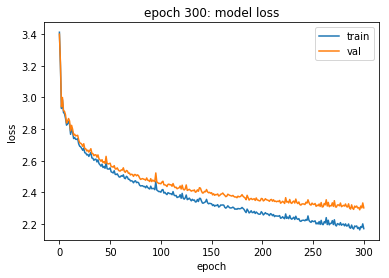

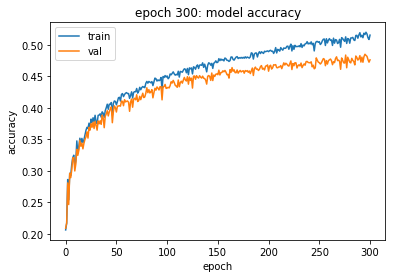



Epoch 301/500 ..............
Loss train:  2.177898164181534 
Loss val:  2.3084184072839324 
Train accuracy:  0.516775 
Validation accuracy:  0.4809
Alpha:  0.001


Epoch 302/500 ..............
Loss train:  2.1823681915037523 
Loss val:  2.313652433440995 
Train accuracy:  0.512825 
Validation accuracy:  0.472
Alpha:  0.001


Epoch 303/500 ..............
Loss train:  2.1624613819907292 
Loss val:  2.293641413543978 
Train accuracy:  0.520725 
Validation accuracy:  0.4821
Alpha:  0.001


Epoch 304/500 ..............
Loss train:  2.164386277569776 
Loss val:  2.291934303419527 
Train accuracy:  0.517475 
Validation accuracy:  0.4809
Alpha:  0.001


Epoch 305/500 ..............
Loss train:  2.173967047349371 
Loss val:  2.3030704982495314 
Train accuracy:  0.516375 
Validation accuracy:  0.4817
Alpha:  0.001


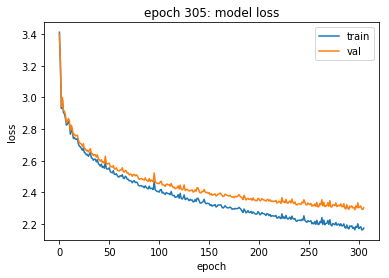

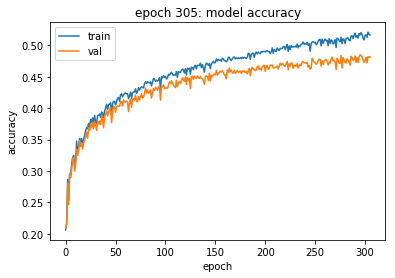



Epoch 306/500 ..............
Loss train:  2.168779938560982 
Loss val:  2.2958334657451416 
Train accuracy:  0.51985 
Validation accuracy:  0.4842
Alpha:  0.001


Epoch 307/500 ..............
Loss train:  2.166668140412161 
Loss val:  2.2980415308109663 
Train accuracy:  0.5184 
Validation accuracy:  0.4844
Alpha:  0.001


Epoch 308/500 ..............
Loss train:  2.1710971473241574 
Loss val:  2.2954948624188733 
Train accuracy:  0.514325 
Validation accuracy:  0.4801
Alpha:  0.001


Epoch 309/500 ..............
Loss train:  2.1918781106024885 
Loss val:  2.323495143106904 
Train accuracy:  0.512175 
Validation accuracy:  0.4765
Alpha:  0.001


Epoch 310/500 ..............
Loss train:  2.164369925006428 
Loss val:  2.295660532651923 
Train accuracy:  0.516975 
Validation accuracy:  0.4816
Alpha:  0.001


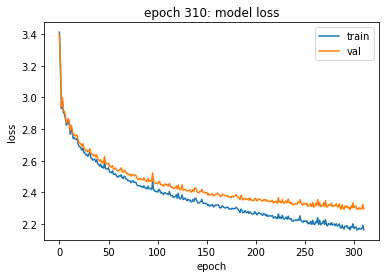

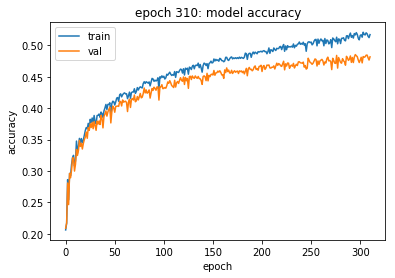



Epoch 311/500 ..............
Loss train:  2.1703789236348148 
Loss val:  2.300700958248809 
Train accuracy:  0.51985 
Validation accuracy:  0.4836
Alpha:  0.001


Epoch 312/500 ..............
Loss train:  2.164323277472728 
Loss val:  2.300344293195643 
Train accuracy:  0.519925 
Validation accuracy:  0.4859
Alpha:  0.001


Epoch 313/500 ..............
Loss train:  2.15803742418804 
Loss val:  2.2940356877216472 
Train accuracy:  0.52185 
Validation accuracy:  0.4814
Alpha:  0.001


Epoch 314/500 ..............
Loss train:  2.169166382403432 
Loss val:  2.3043791220524037 
Train accuracy:  0.5211 
Validation accuracy:  0.4876
Alpha:  0.001


Epoch 315/500 ..............
Loss train:  2.1619096165594245 
Loss val:  2.2989568734718215 
Train accuracy:  0.519825 
Validation accuracy:  0.4781
Alpha:  0.001


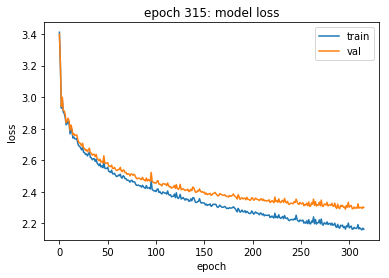

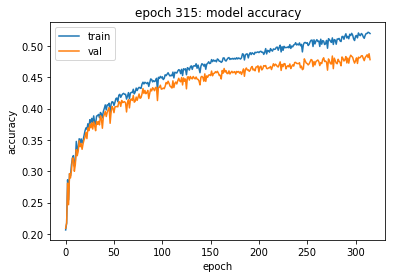



Epoch 316/500 ..............
Loss train:  2.14791321072598 
Loss val:  2.2829233115588266 
Train accuracy:  0.52405 
Validation accuracy:  0.4897
Alpha:  0.001


Epoch 317/500 ..............
Loss train:  2.1574454326917945 
Loss val:  2.2894342838976898 
Train accuracy:  0.521475 
Validation accuracy:  0.482
Alpha:  0.001


Epoch 318/500 ..............
Loss train:  2.1592278464025907 
Loss val:  2.294902692754924 
Train accuracy:  0.51735 
Validation accuracy:  0.4752
Alpha:  0.001


Epoch 319/500 ..............
Loss train:  2.147482948228494 
Loss val:  2.282695128782688 
Train accuracy:  0.522225 
Validation accuracy:  0.4875
Alpha:  0.001


Epoch 320/500 ..............
Loss train:  2.1467095207858238 
Loss val:  2.284596058237778 
Train accuracy:  0.522175 
Validation accuracy:  0.4814
Alpha:  0.001


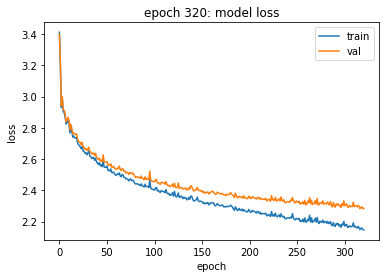

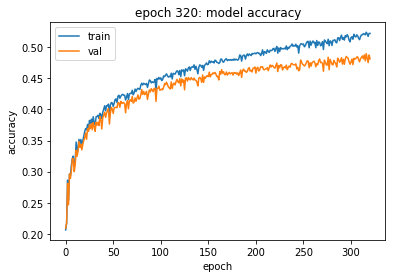



Epoch 321/500 ..............
Loss train:  2.1545803371311747 
Loss val:  2.2938061818322995 
Train accuracy:  0.52265 
Validation accuracy:  0.4865
Alpha:  0.001


Epoch 322/500 ..............
Loss train:  2.1422349845534296 
Loss val:  2.282889583566421 
Train accuracy:  0.524725 
Validation accuracy:  0.4835
Alpha:  0.001


Epoch 323/500 ..............
Loss train:  2.153114985803579 
Loss val:  2.292068763830905 
Train accuracy:  0.5226 
Validation accuracy:  0.4833
Alpha:  0.001


Epoch 324/500 ..............
Loss train:  2.1592769170686728 
Loss val:  2.292777610371672 
Train accuracy:  0.523775 
Validation accuracy:  0.4879
Alpha:  0.001


Epoch 325/500 ..............
Loss train:  2.148101903153629 
Loss val:  2.2863825129476285 
Train accuracy:  0.522125 
Validation accuracy:  0.4817
Alpha:  0.001


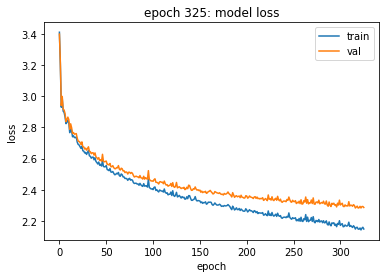

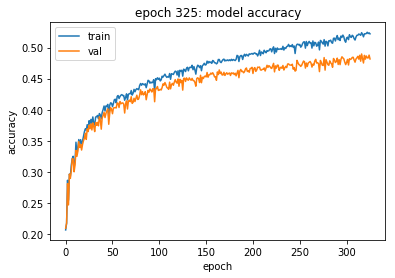



Epoch 326/500 ..............
Loss train:  2.145738170080798 
Loss val:  2.2873247252252806 
Train accuracy:  0.522775 
Validation accuracy:  0.4838
Alpha:  0.001


Epoch 327/500 ..............
Loss train:  2.141233996004908 
Loss val:  2.285975703632302 
Train accuracy:  0.52675 
Validation accuracy:  0.4859
Alpha:  0.001


Epoch 328/500 ..............
Loss train:  2.1476145298493865 
Loss val:  2.286161680618486 
Train accuracy:  0.52395 
Validation accuracy:  0.4823
Alpha:  0.001


Epoch 329/500 ..............
Loss train:  2.1531572412501814 
Loss val:  2.2920799574903015 
Train accuracy:  0.5197 
Validation accuracy:  0.4829
Alpha:  0.001


Epoch 330/500 ..............
Loss train:  2.146901168572664 
Loss val:  2.2912389887788565 
Train accuracy:  0.52415 
Validation accuracy:  0.4823
Alpha:  0.001


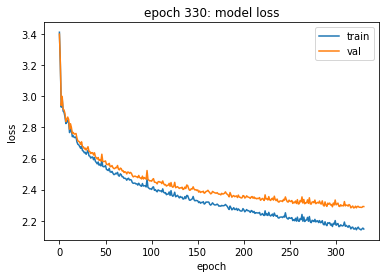

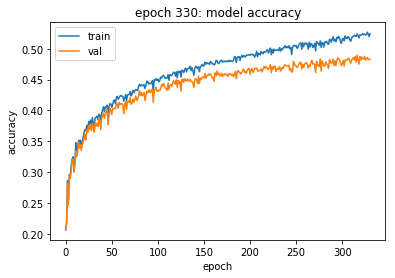



Epoch 331/500 ..............
Loss train:  2.1483459071589843 
Loss val:  2.284429632144104 
Train accuracy:  0.524975 
Validation accuracy:  0.4876
Alpha:  0.001


Epoch 332/500 ..............
Loss train:  2.1438038194507145 
Loss val:  2.2851322453514373 
Train accuracy:  0.5272 
Validation accuracy:  0.4883
Alpha:  0.001


Epoch 333/500 ..............
Loss train:  2.1531396560147353 
Loss val:  2.298699003144678 
Train accuracy:  0.522675 
Validation accuracy:  0.4775
Alpha:  0.001


Epoch 334/500 ..............
Loss train:  2.139122160965902 
Loss val:  2.2820016451395184 
Train accuracy:  0.527825 
Validation accuracy:  0.484
Alpha:  0.001


Epoch 335/500 ..............
Loss train:  2.1566762908479413 
Loss val:  2.297551964607991 
Train accuracy:  0.523775 
Validation accuracy:  0.4835
Alpha:  0.001


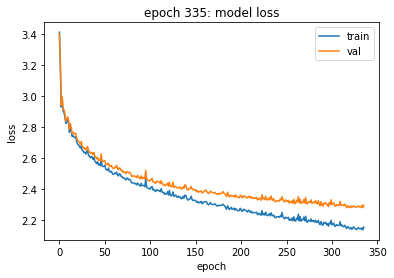

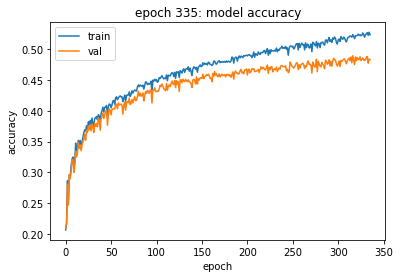



Epoch 336/500 ..............
Loss train:  2.150516112750449 
Loss val:  2.296239672391354 
Train accuracy:  0.52485 
Validation accuracy:  0.4841
Alpha:  0.001


Epoch 337/500 ..............
Loss train:  2.1521113102816662 
Loss val:  2.295586235436362 
Train accuracy:  0.522075 
Validation accuracy:  0.4851
Alpha:  0.001


Epoch 338/500 ..............
Loss train:  2.1393828601833684 
Loss val:  2.2836078098095225 
Train accuracy:  0.52475 
Validation accuracy:  0.4857
Alpha:  0.001


Epoch 339/500 ..............
Loss train:  2.1503203861187217 
Loss val:  2.2886417174489484 
Train accuracy:  0.5192 
Validation accuracy:  0.4823
Alpha:  0.001


Epoch 340/500 ..............
Loss train:  2.1278327011601106 
Loss val:  2.272859215742415 
Train accuracy:  0.53035 
Validation accuracy:  0.4937
Alpha:  0.001


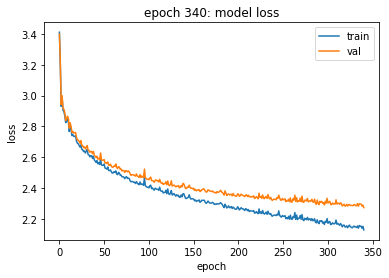

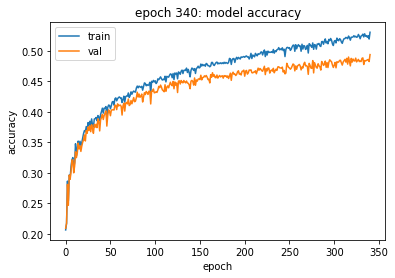



Epoch 341/500 ..............
Loss train:  2.1550196382192874 
Loss val:  2.301275532724263 
Train accuracy:  0.52365 
Validation accuracy:  0.4798
Alpha:  0.001


Epoch 342/500 ..............
Loss train:  2.1278626070360773 
Loss val:  2.2714614392679184 
Train accuracy:  0.5297 
Validation accuracy:  0.4877
Alpha:  0.001


Epoch 343/500 ..............
Loss train:  2.1306973335683512 
Loss val:  2.277379899527106 
Train accuracy:  0.528825 
Validation accuracy:  0.4903
Alpha:  0.001


Epoch 344/500 ..............
Loss train:  2.1283691403620852 
Loss val:  2.275340143608574 
Train accuracy:  0.529525 
Validation accuracy:  0.49
Alpha:  0.001


Epoch 345/500 ..............
Loss train:  2.1285761012438384 
Loss val:  2.2801998855546994 
Train accuracy:  0.53 
Validation accuracy:  0.489
Alpha:  0.001


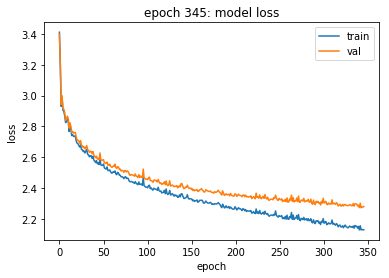

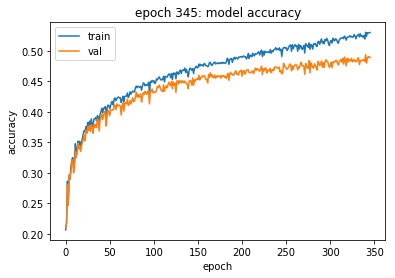



Epoch 346/500 ..............
Loss train:  2.1220661251635344 
Loss val:  2.268717282555597 
Train accuracy:  0.532525 
Validation accuracy:  0.4938
Alpha:  0.001


Epoch 347/500 ..............
Loss train:  2.1534685291866302 
Loss val:  2.2996126172927354 
Train accuracy:  0.523775 
Validation accuracy:  0.4842
Alpha:  0.001


Epoch 348/500 ..............
Loss train:  2.1287411655776554 
Loss val:  2.2764554132559707 
Train accuracy:  0.531 
Validation accuracy:  0.4878
Alpha:  0.001


Epoch 349/500 ..............
Loss train:  2.1369029512016566 
Loss val:  2.2829071915361547 
Train accuracy:  0.529425 
Validation accuracy:  0.4884
Alpha:  0.001


Epoch 350/500 ..............
Loss train:  2.133562576783889 
Loss val:  2.284844491670286 
Train accuracy:  0.528875 
Validation accuracy:  0.4849
Alpha:  0.001


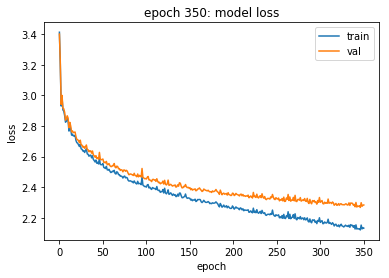

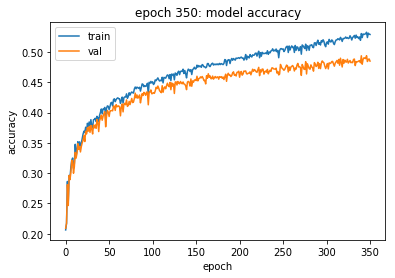



Epoch 351/500 ..............
Loss train:  2.1193727942183154 
Loss val:  2.2648173994322005 
Train accuracy:  0.5335 
Validation accuracy:  0.4963
Alpha:  0.001


Epoch 352/500 ..............
Loss train:  2.127433909226129 
Loss val:  2.275804556584923 
Train accuracy:  0.52815 
Validation accuracy:  0.4911
Alpha:  0.001


Epoch 353/500 ..............
Loss train:  2.1352393850033007 
Loss val:  2.287614387388988 
Train accuracy:  0.527125 
Validation accuracy:  0.4867
Alpha:  0.001


Epoch 354/500 ..............
Loss train:  2.1178203829773232 
Loss val:  2.269123430365789 
Train accuracy:  0.532675 
Validation accuracy:  0.4933
Alpha:  0.001


Epoch 355/500 ..............
Loss train:  2.1355212407215176 
Loss val:  2.285758372352966 
Train accuracy:  0.525375 
Validation accuracy:  0.4863
Alpha:  0.001


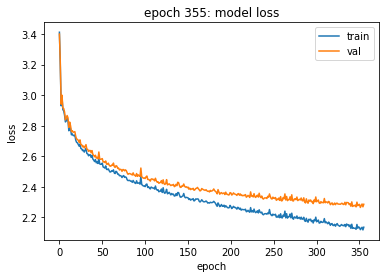

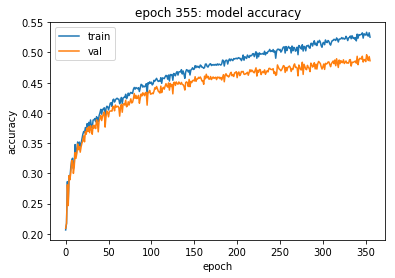



Epoch 356/500 ..............
Loss train:  2.1238199362653276 
Loss val:  2.272696658157925 
Train accuracy:  0.52745 
Validation accuracy:  0.4884
Alpha:  0.001


Epoch 357/500 ..............
Loss train:  2.127863353887585 
Loss val:  2.2828527345374563 
Train accuracy:  0.53055 
Validation accuracy:  0.4857
Alpha:  0.001


Epoch 358/500 ..............
Loss train:  2.1446212131330586 
Loss val:  2.296795406731077 
Train accuracy:  0.5252 
Validation accuracy:  0.4876
Alpha:  0.001


Epoch 359/500 ..............
Loss train:  2.115177835345159 
Loss val:  2.2710831752965914 
Train accuracy:  0.53415 
Validation accuracy:  0.4933
Alpha:  0.001


Epoch 360/500 ..............
Loss train:  2.117502357083347 
Loss val:  2.272314699473325 
Train accuracy:  0.534975 
Validation accuracy:  0.4922
Alpha:  0.001


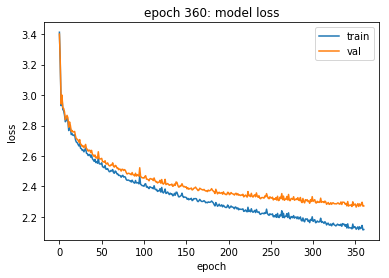

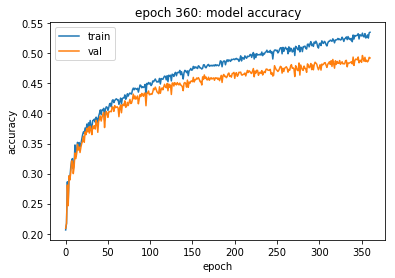



Epoch 361/500 ..............
Loss train:  2.1165186575823745 
Loss val:  2.267474653608695 
Train accuracy:  0.535175 
Validation accuracy:  0.4949
Alpha:  0.001


Epoch 362/500 ..............
Loss train:  2.1164960789554033 
Loss val:  2.2712191986703836 
Train accuracy:  0.535175 
Validation accuracy:  0.4916
Alpha:  0.001


Epoch 363/500 ..............
Loss train:  2.127118225727827 
Loss val:  2.2841458781430704 
Train accuracy:  0.5272 
Validation accuracy:  0.4833
Alpha:  0.001


Epoch 364/500 ..............
Loss train:  2.1226129056699468 
Loss val:  2.2730851424115115 
Train accuracy:  0.53555 
Validation accuracy:  0.4943
Alpha:  0.001


Epoch 365/500 ..............
Loss train:  2.1472921582374935 
Loss val:  2.301542842414757 
Train accuracy:  0.520875 
Validation accuracy:  0.4831
Alpha:  0.001


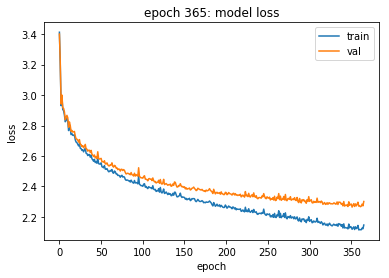

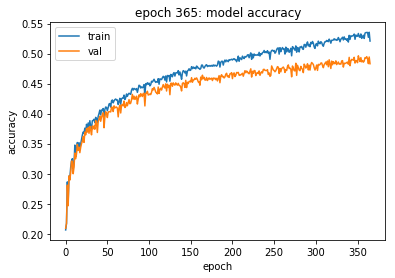



Epoch 366/500 ..............
Loss train:  2.1337812152736224 
Loss val:  2.289495397177921 
Train accuracy:  0.529225 
Validation accuracy:  0.4859
Alpha:  0.001


Epoch 367/500 ..............
Loss train:  2.1116968715209996 
Loss val:  2.266751460273297 
Train accuracy:  0.534625 
Validation accuracy:  0.4941
Alpha:  0.001


Epoch 368/500 ..............
Loss train:  2.1269070898867097 
Loss val:  2.281784135015747 
Train accuracy:  0.52865 
Validation accuracy:  0.4888
Alpha:  0.001


Epoch 369/500 ..............
Loss train:  2.120111578855384 
Loss val:  2.2831006491284564 
Train accuracy:  0.53225 
Validation accuracy:  0.485
Alpha:  0.001


Epoch 370/500 ..............
Loss train:  2.1010370001858045 
Loss val:  2.2611508779553633 
Train accuracy:  0.53875 
Validation accuracy:  0.4955
Alpha:  0.001


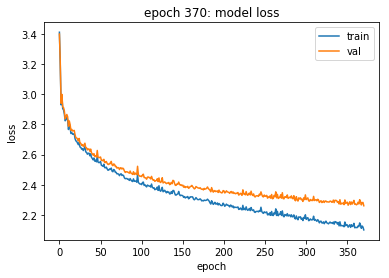

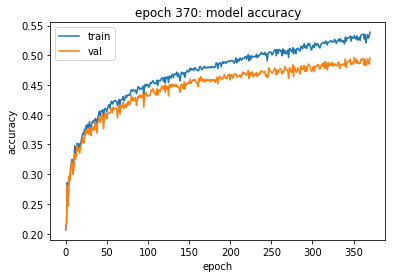



Epoch 371/500 ..............
Loss train:  2.123649138652382 
Loss val:  2.280175336663976 
Train accuracy:  0.5356 
Validation accuracy:  0.4954
Alpha:  0.001


Epoch 372/500 ..............
Loss train:  2.1284061356042807 
Loss val:  2.289501536067429 
Train accuracy:  0.527975 
Validation accuracy:  0.4794
Alpha:  0.001


Epoch 373/500 ..............
Loss train:  2.1105104453588113 
Loss val:  2.2671946452661356 
Train accuracy:  0.533875 
Validation accuracy:  0.4917
Alpha:  0.001


Epoch 374/500 ..............
Loss train:  2.1080643198828075 
Loss val:  2.2668678504621966 
Train accuracy:  0.5356 
Validation accuracy:  0.4912
Alpha:  0.001


Epoch 375/500 ..............
Loss train:  2.1235261551477 
Loss val:  2.2854787921493624 
Train accuracy:  0.533625 
Validation accuracy:  0.4873
Alpha:  0.001


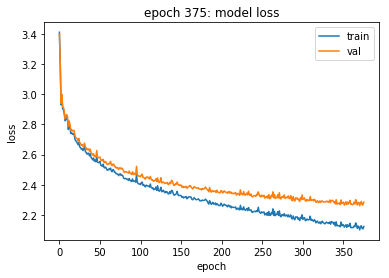

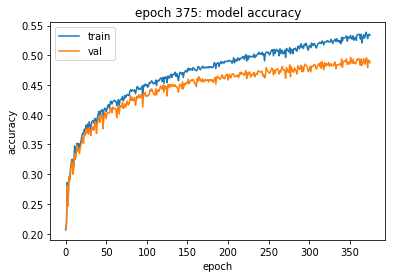



Epoch 376/500 ..............
Loss train:  2.1036705791750903 
Loss val:  2.264431841643179 
Train accuracy:  0.536675 
Validation accuracy:  0.4916
Alpha:  0.001


Epoch 377/500 ..............
Loss train:  2.098743685858635 
Loss val:  2.2613334604292676 
Train accuracy:  0.5398 
Validation accuracy:  0.4921
Alpha:  0.001


Epoch 378/500 ..............
Loss train:  2.105790466143565 
Loss val:  2.267993148361398 
Train accuracy:  0.537125 
Validation accuracy:  0.491
Alpha:  0.001


Epoch 379/500 ..............
Loss train:  2.094697892065809 
Loss val:  2.260489129553269 
Train accuracy:  0.53945 
Validation accuracy:  0.4919
Alpha:  0.001


Epoch 380/500 ..............
Loss train:  2.0978632351599513 
Loss val:  2.2598677799375753 
Train accuracy:  0.53955 
Validation accuracy:  0.4961
Alpha:  0.001


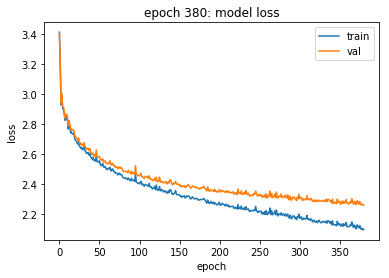

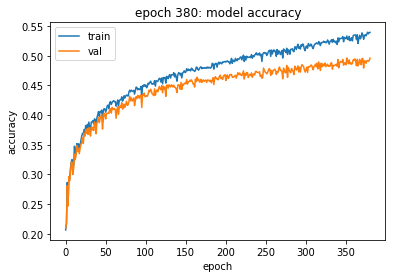



Epoch 381/500 ..............
Loss train:  2.1095732824875575 
Loss val:  2.2737761256129168 
Train accuracy:  0.5329 
Validation accuracy:  0.4867
Alpha:  0.001


Epoch 382/500 ..............
Loss train:  2.0970919380260904 
Loss val:  2.2647784436808864 
Train accuracy:  0.53685 
Validation accuracy:  0.4895
Alpha:  0.001


Epoch 383/500 ..............
Loss train:  2.0982068050061415 
Loss val:  2.261470772354001 
Train accuracy:  0.53815 
Validation accuracy:  0.4952
Alpha:  0.001


Epoch 384/500 ..............
Loss train:  2.111630009152187 
Loss val:  2.2771599583890105 
Train accuracy:  0.533175 
Validation accuracy:  0.4908
Alpha:  0.001


Epoch 385/500 ..............
Loss train:  2.1107617405973667 
Loss val:  2.2756970627642588 
Train accuracy:  0.5365 
Validation accuracy:  0.4877
Alpha:  0.001


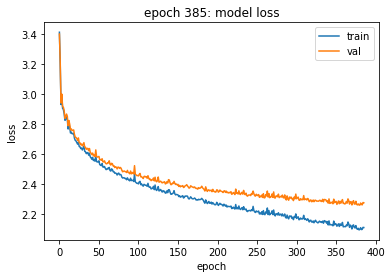

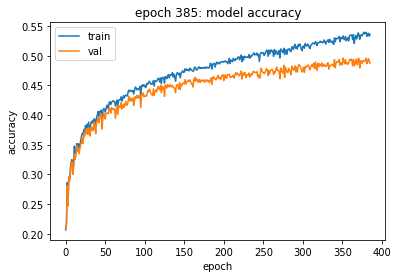



Epoch 386/500 ..............
Loss train:  2.103379632531075 
Loss val:  2.2684843626802125 
Train accuracy:  0.536425 
Validation accuracy:  0.4942
Alpha:  0.001


Epoch 387/500 ..............
Loss train:  2.0958055418428407 
Loss val:  2.259777773990121 
Train accuracy:  0.538625 
Validation accuracy:  0.4948
Alpha:  0.001


Epoch 388/500 ..............
Loss train:  2.0960838933970467 
Loss val:  2.2638087788311023 
Train accuracy:  0.5382 
Validation accuracy:  0.493
Alpha:  0.001


Epoch 389/500 ..............
Loss train:  2.103591842689913 
Loss val:  2.2724181634671883 
Train accuracy:  0.537 
Validation accuracy:  0.4872
Alpha:  0.001


Epoch 390/500 ..............
Loss train:  2.097070671646535 
Loss val:  2.262673471455794 
Train accuracy:  0.54105 
Validation accuracy:  0.4947
Alpha:  0.001


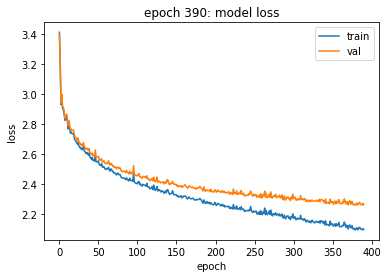

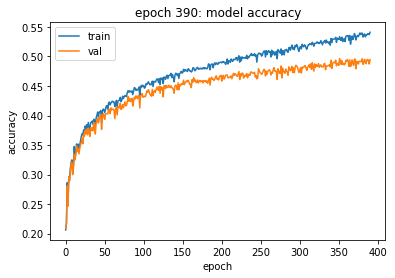



Epoch 391/500 ..............
Loss train:  2.1114102923803117 
Loss val:  2.277075849242627 
Train accuracy:  0.5324 
Validation accuracy:  0.4909
Alpha:  0.001


Epoch 392/500 ..............
Loss train:  2.1017817490279636 
Loss val:  2.2696857404947046 
Train accuracy:  0.5376 
Validation accuracy:  0.4912
Alpha:  0.001


Epoch 393/500 ..............
Loss train:  2.101486779287603 
Loss val:  2.265407169961075 
Train accuracy:  0.534975 
Validation accuracy:  0.4897
Alpha:  0.001


Epoch 394/500 ..............
Loss train:  2.1208036323162895 
Loss val:  2.2894107902516834 
Train accuracy:  0.531975 
Validation accuracy:  0.4872
Alpha:  0.001


Epoch 395/500 ..............
Loss train:  2.0885614933942023 
Loss val:  2.2567704581141927 
Train accuracy:  0.54045 
Validation accuracy:  0.4938
Alpha:  0.001


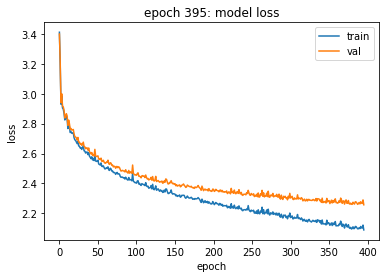

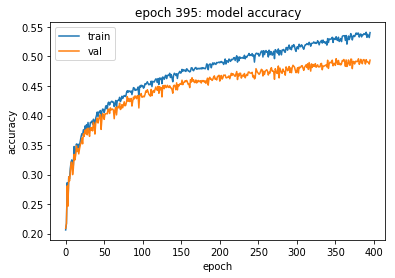



Epoch 396/500 ..............
Loss train:  2.083801269689102 
Loss val:  2.253412866124859 
Train accuracy:  0.5419 
Validation accuracy:  0.4942
Alpha:  0.001


Epoch 397/500 ..............
Loss train:  2.0917432996037895 
Loss val:  2.2617983480513257 
Train accuracy:  0.54195 
Validation accuracy:  0.4953
Alpha:  0.001


Epoch 398/500 ..............
Loss train:  2.08563346362731 
Loss val:  2.2608731206333728 
Train accuracy:  0.543275 
Validation accuracy:  0.4929
Alpha:  0.001


Epoch 399/500 ..............
Loss train:  2.0843754105990016 
Loss val:  2.2550733198964443 
Train accuracy:  0.541625 
Validation accuracy:  0.4964
Alpha:  0.001


Epoch 400/500 ..............
Loss train:  2.098508267537687 
Loss val:  2.2727461676789056 
Train accuracy:  0.540125 
Validation accuracy:  0.4932
Alpha:  0.001


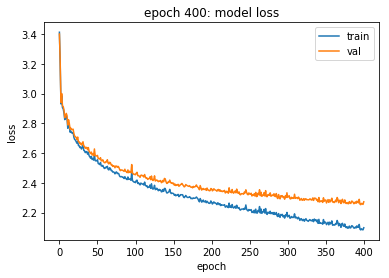

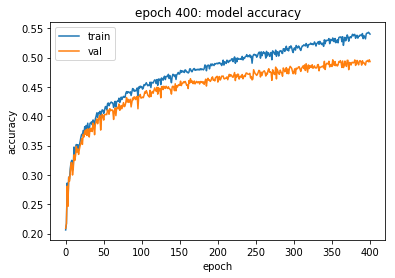



Epoch 401/500 ..............
Loss train:  2.083254877486503 
Loss val:  2.2555876286244363 
Train accuracy:  0.542925 
Validation accuracy:  0.4973
Alpha:  0.001


Epoch 402/500 ..............
Loss train:  2.0954579815271344 
Loss val:  2.2685836355385125 
Train accuracy:  0.537225 
Validation accuracy:  0.4941
Alpha:  0.001


Epoch 403/500 ..............
Loss train:  2.084612921497842 
Loss val:  2.2572227073540443 
Train accuracy:  0.54305 
Validation accuracy:  0.4962
Alpha:  0.001


Epoch 404/500 ..............
Loss train:  2.0896876782514964 
Loss val:  2.267758144628272 
Train accuracy:  0.539225 
Validation accuracy:  0.4938
Alpha:  0.001


Epoch 405/500 ..............
Loss train:  2.085518207758146 
Loss val:  2.262628787986408 
Train accuracy:  0.540925 
Validation accuracy:  0.4923
Alpha:  0.001


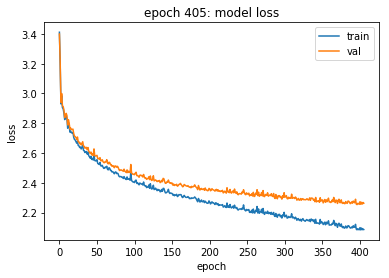

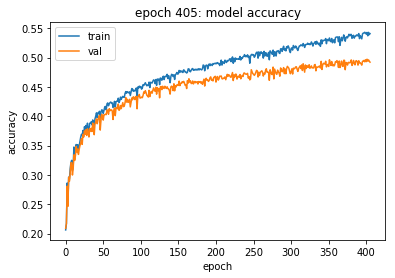



Epoch 406/500 ..............
Loss train:  2.095684675736597 
Loss val:  2.2644146949264594 
Train accuracy:  0.5382 
Validation accuracy:  0.4917
Alpha:  0.001


Epoch 407/500 ..............
Loss train:  2.0893780383717875 
Loss val:  2.2617177503820067 
Train accuracy:  0.540325 
Validation accuracy:  0.4954
Alpha:  0.001


Epoch 408/500 ..............
Loss train:  2.092875539265178 
Loss val:  2.266691833722704 
Train accuracy:  0.54375 
Validation accuracy:  0.4955
Alpha:  0.001


Epoch 409/500 ..............
Loss train:  2.073717248878562 
Loss val:  2.2514742479784347 
Train accuracy:  0.54435 
Validation accuracy:  0.4973
Alpha:  0.001


Epoch 410/500 ..............
Loss train:  2.0727277870363343 
Loss val:  2.2474945341478936 
Train accuracy:  0.547075 
Validation accuracy:  0.497
Alpha:  0.001


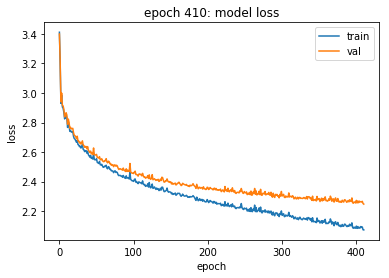

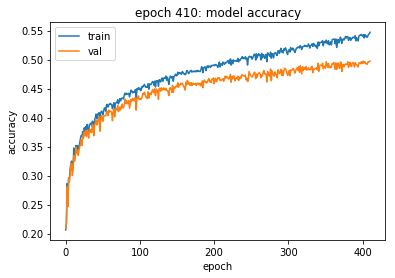



Epoch 411/500 ..............
Loss train:  2.109980343633413 
Loss val:  2.2932769440459526 
Train accuracy:  0.5319 
Validation accuracy:  0.4799
Alpha:  0.001


Epoch 412/500 ..............
Loss train:  2.0741229033716158 
Loss val:  2.2564461281973722 
Train accuracy:  0.546375 
Validation accuracy:  0.4971
Alpha:  0.001


Epoch 413/500 ..............
Loss train:  2.1226716419245637 
Loss val:  2.3082339687748945 
Train accuracy:  0.532125 
Validation accuracy:  0.4872
Alpha:  0.001


Epoch 414/500 ..............
Loss train:  2.0921257902188337 
Loss val:  2.2760400083894607 
Train accuracy:  0.5347 
Validation accuracy:  0.4838
Alpha:  0.001


Epoch 415/500 ..............
Loss train:  2.0914428321739833 
Loss val:  2.26870788171681 
Train accuracy:  0.54625 
Validation accuracy:  0.4967
Alpha:  0.001


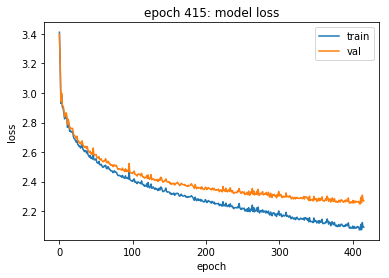

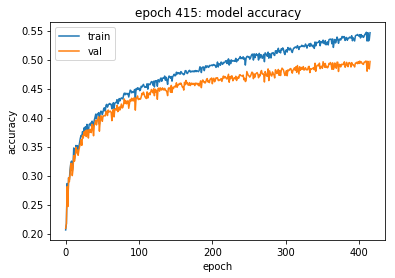



Epoch 416/500 ..............
Loss train:  2.0756933153566175 
Loss val:  2.2586717341046905 
Train accuracy:  0.54565 
Validation accuracy:  0.4943
Alpha:  0.001


Epoch 417/500 ..............
Loss train:  2.078453243799388 
Loss val:  2.2585342817807197 
Train accuracy:  0.54475 
Validation accuracy:  0.5001
Alpha:  0.001


Epoch 418/500 ..............
Loss train:  2.0764332349061196 
Loss val:  2.253146806623158 
Train accuracy:  0.5441 
Validation accuracy:  0.4964
Alpha:  0.001


Epoch 419/500 ..............
Loss train:  2.069087726128487 
Loss val:  2.2491840710349407 
Train accuracy:  0.546475 
Validation accuracy:  0.4973
Alpha:  0.001


Epoch 420/500 ..............
Loss train:  2.0811074549967747 
Loss val:  2.261039293310255 
Train accuracy:  0.54095 
Validation accuracy:  0.4929
Alpha:  0.001


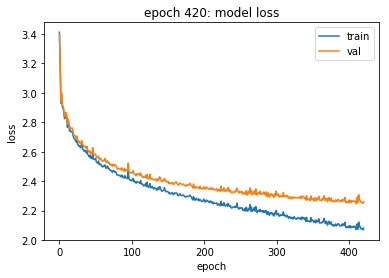

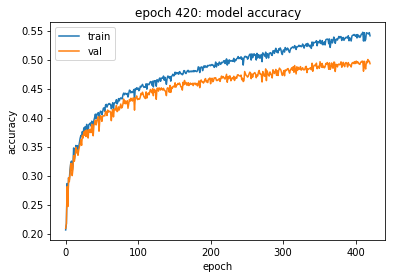



Epoch 421/500 ..............
Loss train:  2.070078564730405 
Loss val:  2.250444943180537 
Train accuracy:  0.548825 
Validation accuracy:  0.4987
Alpha:  0.001


Epoch 422/500 ..............
Loss train:  2.0668962807706945 
Loss val:  2.2509950655745286 
Train accuracy:  0.548325 
Validation accuracy:  0.497
Alpha:  0.001


Epoch 423/500 ..............
Loss train:  2.0734823228589647 
Loss val:  2.2578982266037317 
Train accuracy:  0.542825 
Validation accuracy:  0.4962
Alpha:  0.001


Epoch 424/500 ..............
Loss train:  2.0947424420266003 
Loss val:  2.281618492202258 
Train accuracy:  0.542475 
Validation accuracy:  0.492
Alpha:  0.001


Epoch 425/500 ..............
Loss train:  2.113143125511954 
Loss val:  2.3014091282726765 
Train accuracy:  0.5346 
Validation accuracy:  0.4872
Alpha:  0.001


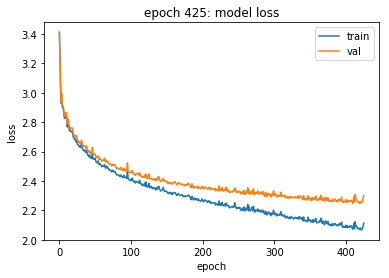

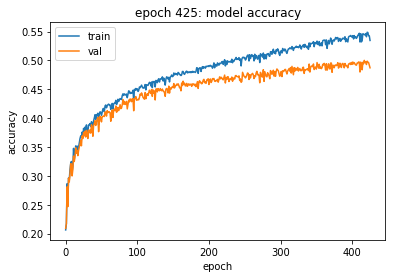



Epoch 426/500 ..............
Loss train:  2.071925185759561 
Loss val:  2.25572092850484 
Train accuracy:  0.5473 
Validation accuracy:  0.4961
Alpha:  0.001


Epoch 427/500 ..............
Loss train:  2.085447021855064 
Loss val:  2.2671914944187423 
Train accuracy:  0.54135 
Validation accuracy:  0.4938
Alpha:  0.001


Epoch 428/500 ..............
Loss train:  2.0752587666046964 
Loss val:  2.263952460804454 
Train accuracy:  0.547 
Validation accuracy:  0.4911
Alpha:  0.001


Epoch 429/500 ..............
Loss train:  2.0629468158734414 
Loss val:  2.2519901141224414 
Train accuracy:  0.5484 
Validation accuracy:  0.4967
Alpha:  0.001


Epoch 430/500 ..............
Loss train:  2.068922456631684 
Loss val:  2.257583655893395 
Train accuracy:  0.547925 
Validation accuracy:  0.4964
Alpha:  0.001


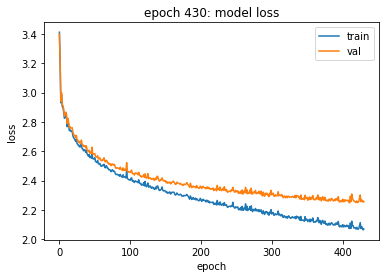

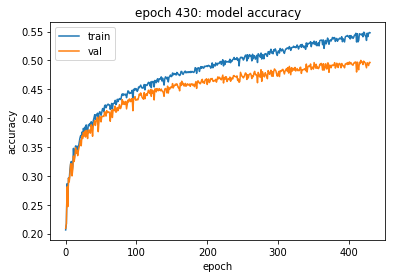



Epoch 431/500 ..............
Loss train:  2.0622330413633927 
Loss val:  2.2487665895598985 
Train accuracy:  0.549125 
Validation accuracy:  0.4985
Alpha:  0.001


Epoch 432/500 ..............
Loss train:  2.0711028618444756 
Loss val:  2.255605367785928 
Train accuracy:  0.545675 
Validation accuracy:  0.4982
Alpha:  0.001


Epoch 433/500 ..............
Loss train:  2.0816513917032693 
Loss val:  2.2649785931678017 
Train accuracy:  0.5437 
Validation accuracy:  0.4936
Alpha:  0.001


Epoch 434/500 ..............
Loss train:  2.0690217981937646 
Loss val:  2.2546582173654275 
Train accuracy:  0.549 
Validation accuracy:  0.499
Alpha:  0.001


Epoch 435/500 ..............
Loss train:  2.0784265283507346 
Loss val:  2.26258377061449 
Train accuracy:  0.547275 
Validation accuracy:  0.4973
Alpha:  0.001


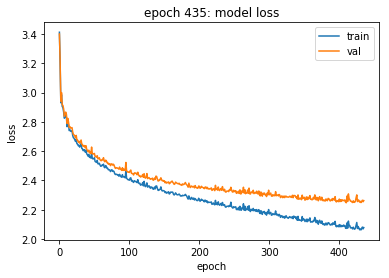

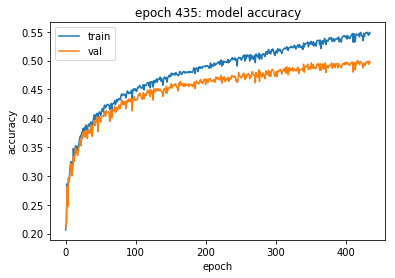



Epoch 436/500 ..............
Loss train:  2.0714750513607765 
Loss val:  2.2620060086259333 
Train accuracy:  0.54955 
Validation accuracy:  0.4975
Alpha:  0.001


Epoch 437/500 ..............
Loss train:  2.07565107904545 
Loss val:  2.256079060911237 
Train accuracy:  0.545525 
Validation accuracy:  0.497
Alpha:  0.001


Epoch 438/500 ..............
Loss train:  2.0717667660912253 
Loss val:  2.2635891139249185 
Train accuracy:  0.549775 
Validation accuracy:  0.4958
Alpha:  0.001


Epoch 439/500 ..............
Loss train:  2.075649631057616 
Loss val:  2.2578707056753626 
Train accuracy:  0.543225 
Validation accuracy:  0.4946
Alpha:  0.001


Epoch 440/500 ..............
Loss train:  2.0518517860117003 
Loss val:  2.239497374527358 
Train accuracy:  0.55355 
Validation accuracy:  0.4999
Alpha:  0.001


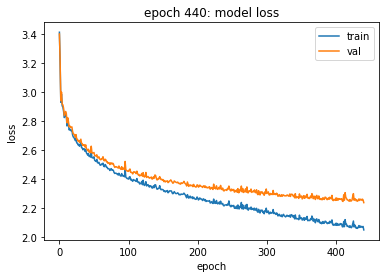

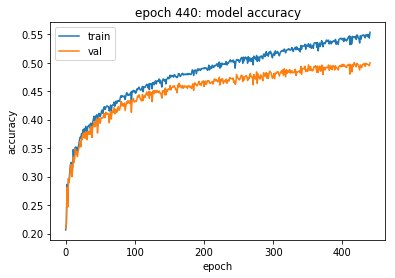



Epoch 441/500 ..............
Loss train:  2.0571722640381696 
Loss val:  2.248227304129327 
Train accuracy:  0.551975 
Validation accuracy:  0.4978
Alpha:  0.001


Epoch 442/500 ..............
Loss train:  2.0692817106286516 
Loss val:  2.254732284153042 
Train accuracy:  0.548475 
Validation accuracy:  0.4949
Alpha:  0.001


Epoch 443/500 ..............
Loss train:  2.0671446449983613 
Loss val:  2.259768801834192 
Train accuracy:  0.54755 
Validation accuracy:  0.496
Alpha:  0.001


Epoch 444/500 ..............
Loss train:  2.0851991807651022 
Loss val:  2.2749265145363062 
Train accuracy:  0.5437 
Validation accuracy:  0.4904
Alpha:  0.001


Epoch 445/500 ..............
Loss train:  2.061426339927393 
Loss val:  2.255177355112137 
Train accuracy:  0.54845 
Validation accuracy:  0.497
Alpha:  0.001


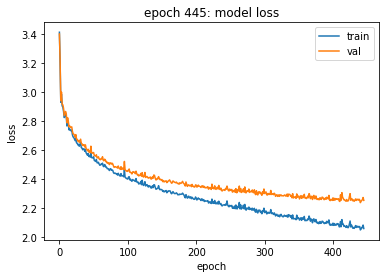

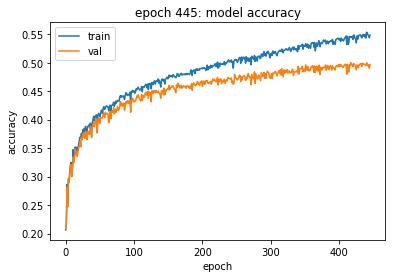



Epoch 446/500 ..............
Loss train:  2.0700489294762936 
Loss val:  2.2642899114767423 
Train accuracy:  0.5479 
Validation accuracy:  0.4908
Alpha:  0.001


Epoch 447/500 ..............
Loss train:  2.0595163819120987 
Loss val:  2.251227095044819 
Train accuracy:  0.5537 
Validation accuracy:  0.4995
Alpha:  0.001


Epoch 448/500 ..............
Loss train:  2.0566155875518635 
Loss val:  2.25180479996498 
Train accuracy:  0.5515 
Validation accuracy:  0.4975
Alpha:  0.001


Epoch 449/500 ..............
Loss train:  2.0696429899856303 
Loss val:  2.2632295514809337 
Train accuracy:  0.54605 
Validation accuracy:  0.4928
Alpha:  0.001


Epoch 450/500 ..............
Loss train:  2.093791436997141 
Loss val:  2.2840482934461144 
Train accuracy:  0.539175 
Validation accuracy:  0.4861
Alpha:  0.001


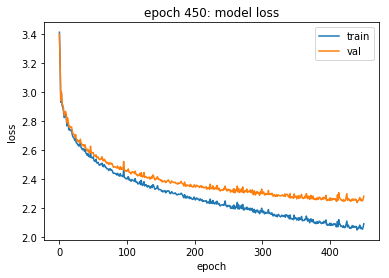

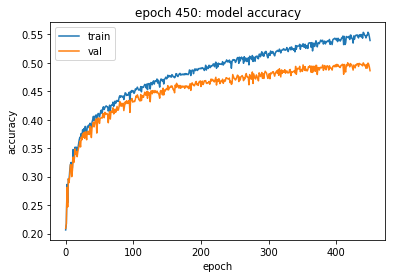



Epoch 451/500 ..............
Loss train:  2.048780244664389 
Loss val:  2.242082048905821 
Train accuracy:  0.552925 
Validation accuracy:  0.5003
Alpha:  0.001


Epoch 452/500 ..............
Loss train:  2.054561718471963 
Loss val:  2.245697908784433 
Train accuracy:  0.5505 
Validation accuracy:  0.4978
Alpha:  0.001


Epoch 453/500 ..............
Loss train:  2.058540008673556 
Loss val:  2.248268600046256 
Train accuracy:  0.5477 
Validation accuracy:  0.4941
Alpha:  0.001


Epoch 454/500 ..............
Loss train:  2.057552934437337 
Loss val:  2.258506943830173 
Train accuracy:  0.550975 
Validation accuracy:  0.5009
Alpha:  0.001


Epoch 455/500 ..............
Loss train:  2.0546560998196313 
Loss val:  2.249212789048938 
Train accuracy:  0.5519 
Validation accuracy:  0.4995
Alpha:  0.001


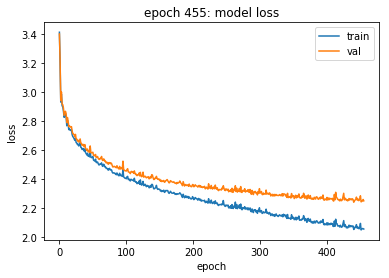

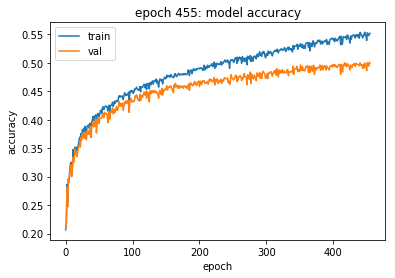



Epoch 456/500 ..............
Loss train:  2.053594686076758 
Loss val:  2.2489871432948965 
Train accuracy:  0.5523 
Validation accuracy:  0.5063
Alpha:  0.001


Epoch 457/500 ..............
Loss train:  2.054095816808965 
Loss val:  2.2512178830814955 
Train accuracy:  0.554375 
Validation accuracy:  0.4971
Alpha:  0.001


Epoch 458/500 ..............
Loss train:  2.066733039811868 
Loss val:  2.2628669224431315 
Train accuracy:  0.552425 
Validation accuracy:  0.5034
Alpha:  0.001


Epoch 459/500 ..............
Loss train:  2.069170695510564 
Loss val:  2.2663913780185645 
Train accuracy:  0.54975 
Validation accuracy:  0.4999
Alpha:  0.001


Epoch 460/500 ..............
Loss train:  2.0714923790770357 
Loss val:  2.2698397671084347 
Train accuracy:  0.542775 
Validation accuracy:  0.4971
Alpha:  0.001


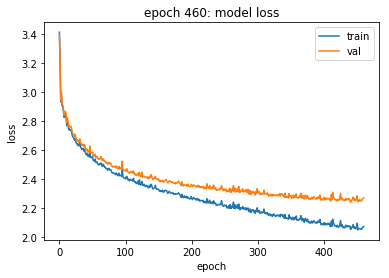

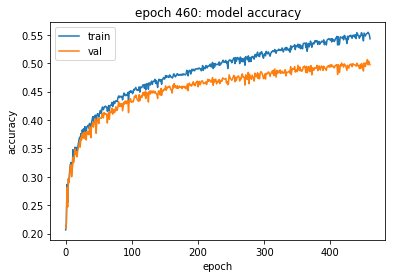



Epoch 461/500 ..............
Loss train:  2.0449654497291516 
Loss val:  2.241666890410267 
Train accuracy:  0.556625 
Validation accuracy:  0.5022
Alpha:  0.001


Epoch 462/500 ..............
Loss train:  2.0621847833934392 
Loss val:  2.259592289276537 
Train accuracy:  0.5507 
Validation accuracy:  0.4954
Alpha:  0.001


Epoch 463/500 ..............
Loss train:  2.0413703001009833 
Loss val:  2.2439702499608134 
Train accuracy:  0.55565 
Validation accuracy:  0.5016
Alpha:  0.001


Epoch 464/500 ..............
Loss train:  2.0584838031949086 
Loss val:  2.2607478707301656 
Train accuracy:  0.547825 
Validation accuracy:  0.491
Alpha:  0.001


Epoch 465/500 ..............
Loss train:  2.073424659121466 
Loss val:  2.272561451853567 
Train accuracy:  0.5438 
Validation accuracy:  0.4929
Alpha:  0.001


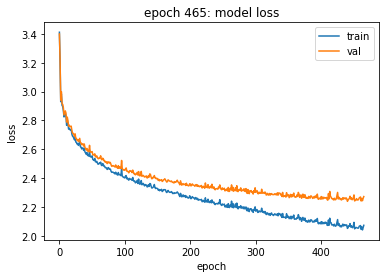

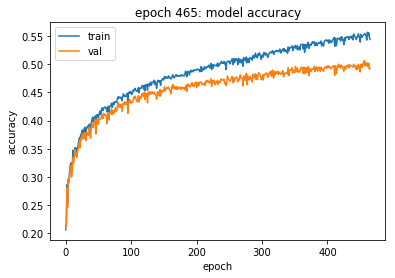



Epoch 466/500 ..............
Loss train:  2.066750522770442 
Loss val:  2.2688116740024618 
Train accuracy:  0.546875 
Validation accuracy:  0.4941
Alpha:  0.001


Epoch 467/500 ..............
Loss train:  2.050890458685925 
Loss val:  2.245391392902131 
Train accuracy:  0.551925 
Validation accuracy:  0.501
Alpha:  0.001


Epoch 468/500 ..............
Loss train:  2.038614226779229 
Loss val:  2.2362217897588272 
Train accuracy:  0.555375 
Validation accuracy:  0.5009
Alpha:  0.001


Epoch 469/500 ..............
Loss train:  2.0451258901349796 
Loss val:  2.2458637561009813 
Train accuracy:  0.55205 
Validation accuracy:  0.5003
Alpha:  0.001


Epoch 470/500 ..............
Loss train:  2.039427353370799 
Loss val:  2.243323179496361 
Train accuracy:  0.5571 
Validation accuracy:  0.4991
Alpha:  0.001


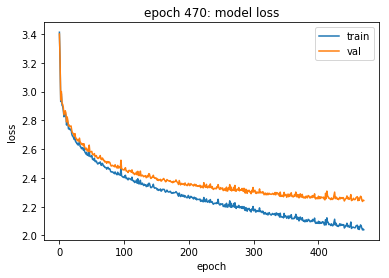

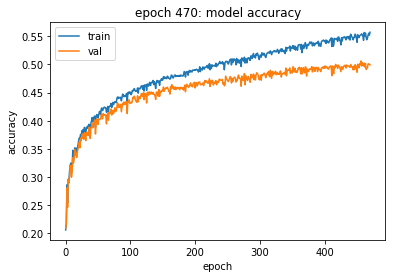



Epoch 471/500 ..............
Loss train:  2.053990734070134 
Loss val:  2.257021813787563 
Train accuracy:  0.54895 
Validation accuracy:  0.4997
Alpha:  0.001


Epoch 472/500 ..............
Loss train:  2.0546254041500447 
Loss val:  2.25843833776451 
Train accuracy:  0.550775 
Validation accuracy:  0.4975
Alpha:  0.001


Epoch 473/500 ..............
Loss train:  2.0328990487847354 
Loss val:  2.2373795482469316 
Train accuracy:  0.558025 
Validation accuracy:  0.5029
Alpha:  0.001


Epoch 474/500 ..............
Loss train:  2.045066421720198 
Loss val:  2.246681044711783 
Train accuracy:  0.55665 
Validation accuracy:  0.5051
Alpha:  0.001


Epoch 475/500 ..............
Loss train:  2.0494364377478242 
Loss val:  2.254009415497686 
Train accuracy:  0.553075 
Validation accuracy:  0.4941
Alpha:  0.001


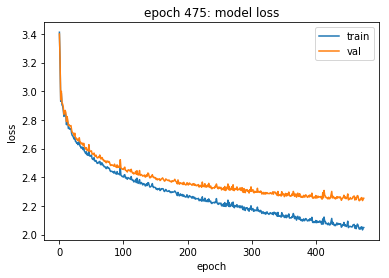

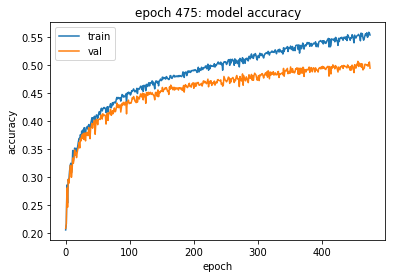



Epoch 476/500 ..............
Loss train:  2.0343537869124577 
Loss val:  2.235312397348614 
Train accuracy:  0.5575 
Validation accuracy:  0.504
Alpha:  0.001


Epoch 477/500 ..............
Loss train:  2.0594326824712135 
Loss val:  2.2603736656055022 
Train accuracy:  0.5506 
Validation accuracy:  0.4972
Alpha:  0.001


Epoch 478/500 ..............
Loss train:  2.043330041807305 
Loss val:  2.2456990047588383 
Train accuracy:  0.555425 
Validation accuracy:  0.5004
Alpha:  0.001


Epoch 479/500 ..............
Loss train:  2.0386834280714816 
Loss val:  2.2427578060035183 
Train accuracy:  0.5599 
Validation accuracy:  0.5027
Alpha:  0.001


Epoch 480/500 ..............
Loss train:  2.0442368207140977 
Loss val:  2.2447348303541674 
Train accuracy:  0.5548 
Validation accuracy:  0.4992
Alpha:  0.001


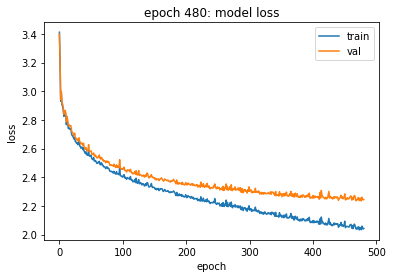

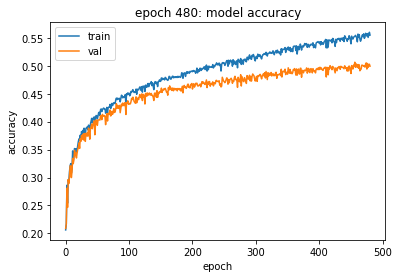



Epoch 481/500 ..............
Loss train:  2.0423956771316787 
Loss val:  2.2474409067762533 
Train accuracy:  0.5527 
Validation accuracy:  0.5013
Alpha:  0.001


Epoch 482/500 ..............
Loss train:  2.0487423470748487 
Loss val:  2.2544977197605025 
Train accuracy:  0.548725 
Validation accuracy:  0.4975
Alpha:  0.001


Epoch 483/500 ..............
Loss train:  2.0433548807161195 
Loss val:  2.255572513357234 
Train accuracy:  0.55295 
Validation accuracy:  0.4928
Alpha:  0.001


Epoch 484/500 ..............
Loss train:  2.0488450998858245 
Loss val:  2.2585246141290423 
Train accuracy:  0.552975 
Validation accuracy:  0.4968
Alpha:  0.001


Epoch 485/500 ..............
Loss train:  2.047827828272192 
Loss val:  2.256914927014824 
Train accuracy:  0.55425 
Validation accuracy:  0.5
Alpha:  0.001


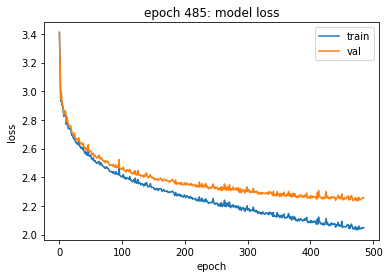

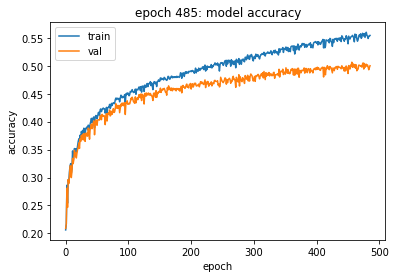



Epoch 486/500 ..............
Loss train:  2.042418495330749 
Loss val:  2.251741439845386 
Train accuracy:  0.556925 
Validation accuracy:  0.4989
Alpha:  0.001


Epoch 487/500 ..............
Loss train:  2.0329046773701682 
Loss val:  2.241432605033558 
Train accuracy:  0.5592 
Validation accuracy:  0.5077
Alpha:  0.001


Epoch 488/500 ..............
Loss train:  2.039364016136137 
Loss val:  2.2487575416906886 
Train accuracy:  0.5554 
Validation accuracy:  0.4993
Alpha:  0.001


Epoch 489/500 ..............
Loss train:  2.050210763985928 
Loss val:  2.2603697212580838 
Train accuracy:  0.55375 
Validation accuracy:  0.4967
Alpha:  0.001


Epoch 490/500 ..............
Loss train:  2.0316432089918193 
Loss val:  2.237988582518919 
Train accuracy:  0.5563 
Validation accuracy:  0.5019
Alpha:  0.001


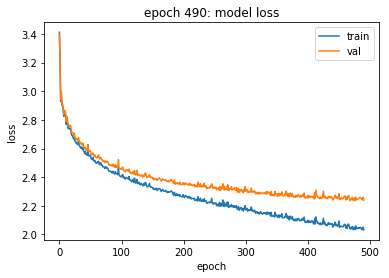

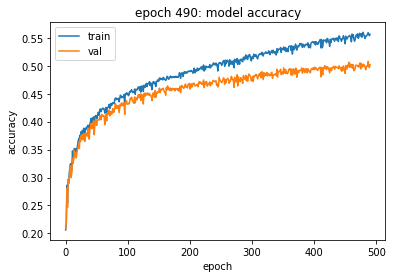



Epoch 491/500 ..............
Loss train:  2.0442196613970203 
Loss val:  2.251680304519714 
Train accuracy:  0.55635 
Validation accuracy:  0.5005
Alpha:  0.001


Epoch 492/500 ..............
Loss train:  2.0323087417684436 
Loss val:  2.242765458716238 
Train accuracy:  0.559325 
Validation accuracy:  0.503
Alpha:  0.001


Epoch 493/500 ..............
Loss train:  2.029535126141007 
Loss val:  2.239450708653466 
Train accuracy:  0.5575 
Validation accuracy:  0.5007
Alpha:  0.001


Epoch 494/500 ..............
Loss train:  2.0245289442633965 
Loss val:  2.236398604117092 
Train accuracy:  0.5621 
Validation accuracy:  0.5057
Alpha:  0.001


Epoch 495/500 ..............
Loss train:  2.022071366341056 
Loss val:  2.2396249160775366 
Train accuracy:  0.55975 
Validation accuracy:  0.5025
Alpha:  0.001


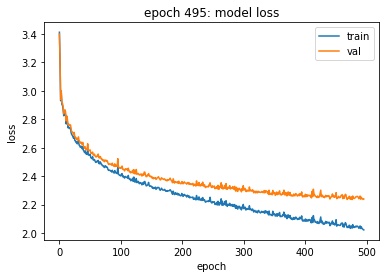

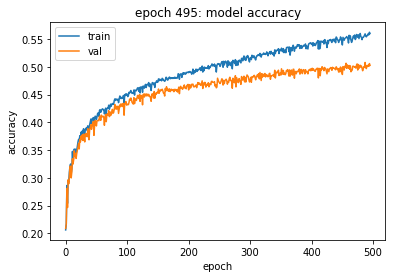



Epoch 496/500 ..............
Loss train:  2.0289553687787607 
Loss val:  2.2388164611857975 
Train accuracy:  0.55975 
Validation accuracy:  0.5023
Alpha:  0.001


Epoch 497/500 ..............
Loss train:  2.0370270677661932 
Loss val:  2.253026779446215 
Train accuracy:  0.558425 
Validation accuracy:  0.5029
Alpha:  0.001


Epoch 498/500 ..............
Loss train:  2.059091352514698 
Loss val:  2.2720365619399683 
Train accuracy:  0.554225 
Validation accuracy:  0.5063
Alpha:  0.001


Epoch 499/500 ..............
Loss train:  2.0275638357670944 
Loss val:  2.243366961652755 
Train accuracy:  0.559975 
Validation accuracy:  0.4983
Alpha:  0.001


In [50]:
batch_size = 1024
dropout_prob = 0.7
num_epochs = 500
alpha = 0.1
history_loss_train,history_loss_val, history_acc_train, history_acc_val = [],[],[],[]
num_train_samples = x_train.shape[0]
num_batches = num_train_samples // batch_size
layers_size = [3072,64,256,10]
#thetas = np.asarray([np.random.randn(layers_size[i], layers_size[i+1]) for i in range(0, len(layers_size)-1)])
thetas = init_thetas(layers_size)
y_pred = forward(thetas, x_train,dropout_prob, False)
loss_val = loss(y_train, y_pred[-1])
print("Initial loss :", loss_val)
Et = np.asarray([np.zeros(th.shape) for th in thetas])
RMS = np.asarray([np.zeros(th.shape) for th in thetas])
for i in range(0, num_epochs):
    p = np.random.permutation(num_train_samples)
    print('\n\nEpoch %d/%d ' % (i, num_epochs), end='.')
    for batch_no in range(0, num_batches):
        if np.mod(batch_no, num_batches // 10) == 0:
            print('.', end='')
            sys.stdout.flush()
        
        x_train_batch = x_train[p[batch_no * batch_size : (batch_no + 1) * batch_size], :]
        y_train_batch = y_train[p[batch_no * batch_size: (batch_no + 1) * batch_size]]
        d_theta = backward(x_train_batch, y_train_batch, thetas,dropout_prob)
        for j in range(0,len(d_theta)):
            Et[j], RMS[j], delta = Adadelta(Et[j], d_theta[j], 0.975, RMS[j], 10**-8) #Adadelta
            #Et[j], delta = RMSprob(Et[j], d_theta[j], 0.9, alpha, 10**-8) #RMSprop
            #thetas[j] =thetas[j] - alpha*d_theta[j] #Обычный mini-batch BackProp
            thetas[j] = thetas[j] - delta 
  
    #loss train
    pred_train_probs = forward(thetas, x_train,dropout_prob, False)
    y_train_out = pred_train_probs[-1]
    loss_train = loss(y_train,  y_train_out)
    history_loss_train.append(loss_train)
    
    #loss val
    pred_val_probs = forward(thetas, x_val,dropout_prob, False)
    y_val_out = pred_val_probs[-1]
    loss_val = loss(y_val, y_val_out)
    history_loss_val.append(loss_val)
    
    history_acc_train.append(acc(y_train, y_train_out))
    history_acc_val.append(acc(y_val, y_val_out))
    print("\nLoss train: ", loss_train,
          "\nLoss val: ", loss_val,
          "\nTrain accuracy: ",acc(y_train, y_train_out),
          "\nValidation accuracy: ", acc(y_val, y_val_out))
    print("Alpha: ", alpha)
    #alpha = max(0.00001, alpha * 0.5)#изменение шага градиента (сначала идем большими, постепенно уменьшая)
    if len(history_loss_val) >= 2:
        if history_loss_val[-2] - history_loss_val[-1] < 0.0005:
            alpha = max(alpha/2, 0.001)
    if (np.mod(i, num_epochs // (num_epochs/5)) == 0) and i != 0:#каждые 10 выводим на экран
        plt.plot(history_loss_train)
        plt.plot(history_loss_val)
        plt.title(f'epoch {i}: model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper right')
        plt.show()

        plt.plot(history_acc_train)
        plt.plot(history_acc_val)
        plt.title(f'epoch {i}: model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()


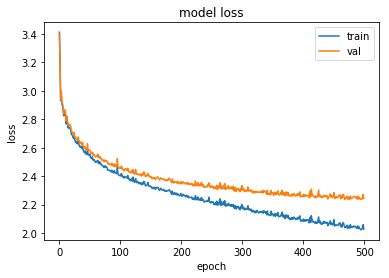

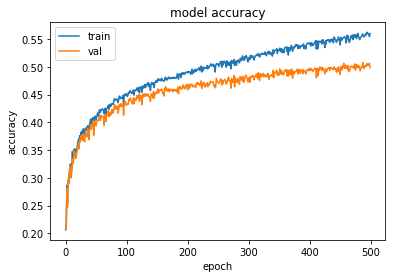

In [51]:
plt.plot(history_loss_train)
plt.plot(history_loss_val)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

plt.plot(history_acc_train)
plt.plot(history_acc_val)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [52]:
pred_test_probs = forward(thetas, x_test,dropout_prob, False)
y_test_out = pred_test_probs[-1]
loss_test = loss(y_test, y_test_out)
print("\nLoss test:", loss_test,
          "\nTest accuracy : ",acc(y_test, y_test_out))


Loss test: 2.2253829812968497 
Test accuracy :  0.5063


In [53]:
import pickle
pickle.dump(thetas, open('weights\\thetasTwoHidLay64-256_Adadelta_500epochs.pkl', 'wb'))

In [54]:
f = open('results_Khayrkina5710M.txt','w')
for y in y_test_out:
    f.write(str(np.argmax(y))+'\n')
f.close()